<a href="https://colab.research.google.com/github/samuelhurni/hslu_ai_hs23/blob/main/Kopie_von_99_AI_Kaggle_Project_Neural_Network_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Planet: Understanding the Amazon from Space
##Use satellite data to track the human footprint in the Amazon rainforest

Project HSLU Master IT Digitalization & Sustainability
Module: Artificial Intelligence
Group:
* Samuel Hurni
* Mario Holzheu
* Chakravarti Devanandini


### 0.1 General information and references

Used Third party Libraries:
* Pytorch
* TQDM
* Pandas
* Numpy
* gdown
* Matplotlib

Used Thid party Imports:
* Helper functions Machine Learning from: "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py

References to Turtorials / Code documantation:
* Pytorch documentation: https://pytorch.org/docs/stable/index.html
* Pytorch Turtorial: https://www.learnpytorch.io/00_pytorch_fundamentals/
* Kaggel dataset for ideas: https://www.kaggle.com/code/vincentmaladiere/pytorch-resnet18-0-93
  * used method `find_best_thresholds()`

### 0.2 About the project

Link to the project as follow: https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space


Main objectives:
n this competition, Planet and its Brazilian partner SCCON are challenging Kagglers to label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond.


Dataset:
* Supervised Multi-Label classification problem with the labels: `agriculture, artisinal_mine, bare_ground, blooming, blow_down, clear, cloudy, conventional_mine, cultivation, habitation, haze, partly_cloudy, primary, road, selective_logging, slash_burn, water`
* Dataset with around 40'000 images for training and around 60'000 images for testing
* For the testing data there aren't labels available, therefore we are using in this jupiter notebook just the training data to train and validate

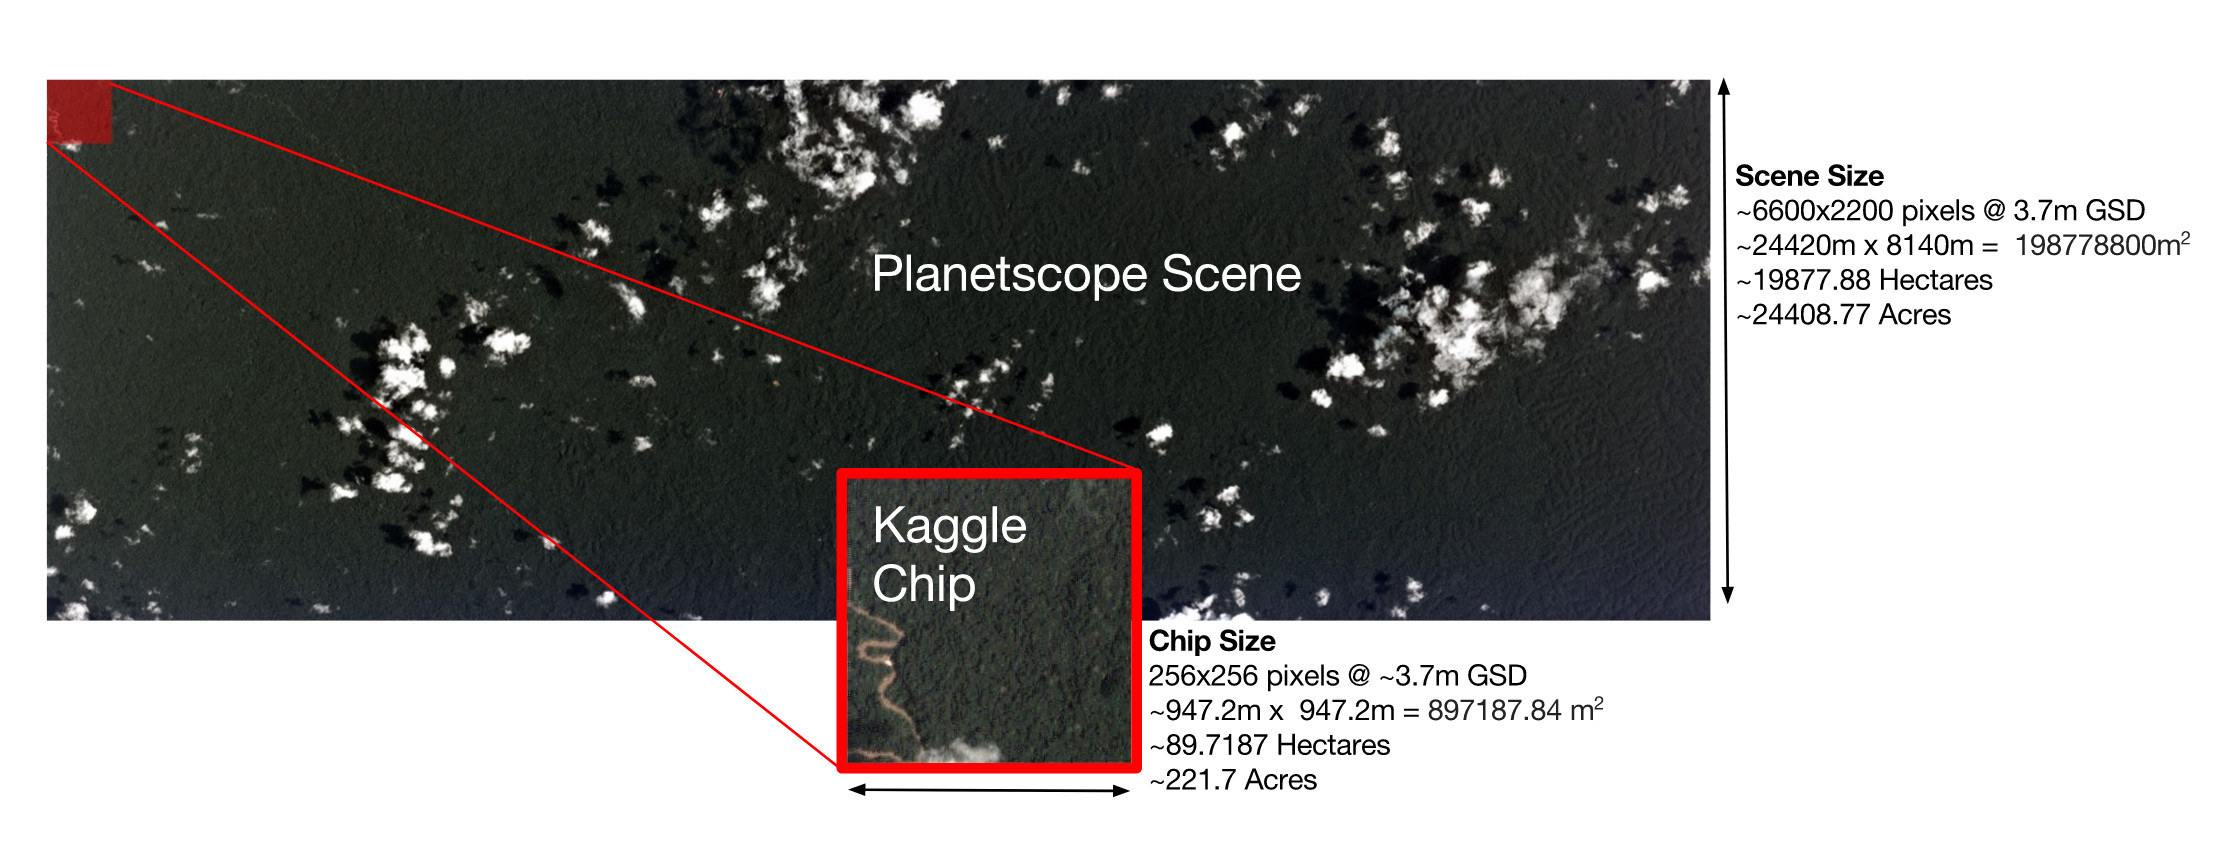



## 1. Preparations: Loading Dataset and install or import Packages

### 1.1 Install adn import third party packages / functions

In this chapter we install the third party packages which maybe are not installed in the prebuild google collab or on your local system

* Tqdm --> progress bar
* gdown --> Import google drive package



In [1]:
# Install gdown:
try:
    import gdown
except ImportError:
    !pip install gdown

# Install tqdm:
try:
    import tqdm
except ImportError:
    !pip install tqdm

In [2]:
# General Import which are used in this file
import pandas as pd
import numpy as np
import string
import os.path
import os
from tqdm.auto import tqdm
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import requests
import requests
import zipfile
from pathlib import Path
import gdown
from sklearn.metrics import fbeta_score


In [3]:
# Download third party helper functions for machine learning:
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper functions.py


### 1.2 Define custom functions for this Project:

In this chapter we are defining custom functions which we are using throughout this project:

* `show_train_time` function to show the time how long the coputation of the model takes
* `folder_content` function to display what is inside a folder
* `check_drop_image_existence` function to drop from the label dataset images which are not in the file system
* `accuracy_fn` function for multi-label calssification problems
* `plot_loss_values` for plotting the loss and accuracy to detect under or overfitting



In [4]:
# Define the timing function:
from timeit import default_timer as timer
def show_train_time(start:float,
                     end:float,
                     device: torch.device = None):
  """Show differnences between start and end time for calculation the performance of a pytorch model"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time


In [5]:
def folder_content(directory_path):
  """
  Iterating thorugh all folders in the path and display the content.
  Args:
    directory_path --> Path to start iteration

  Returns:
    Show information about:
      subdiretories in dir_path
      number of files in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(directory_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
def check_drop_image_existence(label_data: pd.DataFrame, images_dir : string):
  """
  Method which cleans the label dataframe by checking the existence of images
  """
  data_frame = label_data
  index_drop = []
  #print(f"Check Images in Folder {images_dir}")
  for index, row in tqdm(data_frame.iterrows(), desc="Checking if File Exists....."):
    path_to_check = os.path.join(images_dir, row['image_name'])
    file_exists = os.path.isfile(path_to_check)
    if file_exists == False:
      # File does not exist, drop row from dataset
      #print(f"File: {row['image_name']} in Label file does not exist as image and will be deleted from the label file")
      index_drop.append(index)

  #Drop all rows in index_drop
  for index in tqdm(index_drop, desc="Deleting rows in label dataset....."):
    data_frame.drop(index, inplace=True)
  return data_frame

In [7]:
# Define the accuracy function:
def accuracy_fn(y_true, y_pred, threshold=0.5):
    """
    Calculates accuracy between truth labels and predictions for multi-label classification.

    Args:
        y_true (torch.Tensor): Truth labels for predictions. Size: [batch_size, num_labels]
        y_pred (torch.Tensor): Predictions to be compared to predictions. Size: [batch_size, num_labels]
        threshold (float): Threshold value for classifying as 0 or 1.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    # Debug
    #print(y_true.shape)
    #print(y_pred.shape)

    y_pred = (y_pred > threshold).float()  # Convert to 0 or 1 based on threshold
    # could be of shape [[True, False, False ... 17 labels],[False, False, True ... 17 labels]]
    correct = torch.eq(y_true, y_pred).sum().item()

    # For multi-label, we calculate accuracy as correctly predicted labels / total labels.
    total_labels = y_true.numel()
    acc = (correct / total_labels) * 100
    return acc


In [8]:
from typing import Dict, List
def plot_loss_values(results: Dict[str,List[float]]):
  """
    Plot the loss values in a plot tho show if the model is overfitting or underfitting
  """
  #epochs
  epochs = range(len(results['train_loss']))

  # Access Loss
  train_loss = results['train_loss']
  test_loss = results['test_loss']

  # Access Accuracy
  train_accuracy = results['train_accuracy']
  test_accuracy = results['test_accuracy']

  # F2 Score
  train_score = results['train_score']
  test_score = results['test_score']


  # Plot
  plt.figure(figsize=(12,5))

  # Plot loss
  plt.subplot(1,3,1)
  plt.plot (epochs, train_loss, label='train_loss', color='red')
  plt.plot (epochs, test_loss, label='test_loss', color='blue')
  plt.title('Loss:')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot accuracy
  plt.subplot(1,3,2)
  plt.plot (epochs, train_accuracy, label='train_accuracy',color='red')
  plt.plot (epochs, test_accuracy, label='test_accuracy',color='blue')
  plt.title('Accuracy:')
  plt.xlabel('Epochs')
  plt.legend()

  if len(train_score) > 0 and len(test_score) > 0:
    #Plot accuracy
    plt.subplot(1,3,3)
    plt.plot (epochs, train_score, label='train_score',color='red')
    plt.plot (epochs, test_score, label='test_score',color='blue')
    plt.title('F2-Score:')
    plt.xlabel('Epochs')
    plt.legend()




In [74]:

def model_rating(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device,
               multiclass = False):
  """Returns a predictions results and data loader data"""
  loss= 0
  accuracy = 0
  score_f2 = 0
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # data to the slected device
      X, y = X.to(device), y.to(device)

      #predictions
      y_pred = model(X)

      # Accumulate the loss and accuracy values per batch
      loss += loss_fn(y_pred,y)
      if multiclass:
        _, y_pred = torch.max(y_pred, 1)
      accuracy += accuracy_fn(y_true=y,
                              y_pred=y_pred)
      #Calculate F2 Score
      if multiclass == False:
        threshold = 0.5
        binary_test_pred = (y_pred > threshold).float()
        score_f2 += fbeta_score(y.cpu().numpy(), binary_test_pred.cpu().numpy(), beta=2, average="samples") * 100

    #Scale loss and accuracy
    score_f2 /= len(data_loader)
    loss /= len(data_loader)
    accuracy /= len(data_loader)
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": accuracy,
          "model_score": score_f2}



In [10]:
# Making preditions Mulitlabel classification
def make_pred(model: torch.nn.Module,
              data: list,
              device: torch.device):
    """
    Making predictions with a given dataset and a trained model for multi-label classification
    """
    pred_probs = []
    # Load model to the specified device
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for image in data:
            # Prepare the sample (add batch dimension and pass to the target device)
            sample = torch.unsqueeze(image, dim=0).to(device)
            #print(sample.shape)
            # Forward pass (model outputs raw logits)
            pred_logits = model(sample)
            #print(pred_logits)
            # Get prediction probabilities (logits --> prediction probabilities)
            # Using sigmoid for multi-label classification
            pred_prob = torch.sigmoid(pred_logits.squeeze())
            #print(pred_prob)
            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn the list into a tensor
    return torch.stack(pred_probs)

In [11]:
import torch

def combine_models_predictions_2(multilabel_output, multiclass_probabilities, threshold=None):
    """
    Combines the output from multilabel and multiclass classifications into a single tensor.

    Parameters:
    multilabel_output (Tensor): A tensor of probabilities from the multilabel classification (length 13).
    multiclass_probabilities (Tensor): A tensor of probabilities from the multiclass classification (length 4).
    threshold (float, optional): Threshold for converting multilabel probabilities to binary labels. If None, raw probabilities are used.

    Returns:
    Tensor: A combined tensor of 17 labels (4 from multiclass and 13 from multilabel).
    """
    # Convert multiclass probabilities to one-hot encoded label
    multiclass_label = torch.argmax(multiclass_probabilities)
    multiclass_output = torch.nn.functional.one_hot(multiclass_label, num_classes=4)

    # Check if threshold is provided
    if threshold is not None:
        # Convert multilabel probabilities to binary labels using the threshold
        multilabel_output = (multilabel_output >= threshold).int()

    # Combine the two outputs
    combined_output = torch.cat((multiclass_output, multilabel_output), dim=0)

    return combined_output


In [12]:
import torch

def make_pred_combined(multiclass_model: torch.nn.Module,
                       multilabel_model: torch.nn.Module,
                       data: list,
                       device: torch.device,
                       threshold=None):
    """
    Making combined predictions with a given dataset using both multiclass and multilabel models.

    Parameters:
    multiclass_model (torch.nn.Module): The trained multiclass classification model.
    multilabel_model (torch.nn.Module): The trained multilabel classification model.
    data (list): The dataset for making predictions.
    device (torch.device): The device to use for computation (CPU/GPU).
    threshold (float): The threshold for converting multilabel probabilities to binary.

    Returns:
    List[Tensor]: A list of combined predictions from both models.
    """
    combined_pred_probs = []

    # Load models to the specified device
    multiclass_model.to(device)
    multilabel_model.to(device)

    # Set models to evaluation mode
    multiclass_model.eval()
    multilabel_model.eval()

    with torch.inference_mode():
        for image in data:
            # Prepare the sample
            sample = torch.unsqueeze(image, dim=0).to(device)

            # Predict with multiclass model
            multiclass_logits = multiclass_model(sample)
            multiclass_prob = torch.softmax(multiclass_logits.squeeze(), dim=0)

            # Predict with multilabel model
            multilabel_logits = multilabel_model(sample)
            multilabel_prob = torch.sigmoid(multilabel_logits.squeeze())

            # Combine predictions
            combined_prob = combine_models_predictions_2(multilabel_prob, multiclass_prob, threshold)

            # Append to list
            combined_pred_probs.append(combined_prob.cpu())

    return combined_pred_probs

### 1.3 Checking for GPU and device agnostic code (Cuda(Nvidia / Apple Silicon)

In this chapter we are checking if Hardware from Nvidia (Cuda framework) pr Apple Silicon (M1-M3) is available and switching the device

In [13]:
#Setup device agnostic code
import torch
device="cpu"
if torch.backends.mps.is_available():
  print("Metal available with Apple Silicon GPU")
  device = "mps"
elif torch.cuda.is_available():
  device = "cuda"
  print("Cuda available with Nvidia GPU")


Cuda available with Nvidia GPU


### 1.4 Define Hyperparameter for Project:
Her we have the hyperparameters for all three models:

In [14]:
# Dataset
BATCH_SIZE = 50
IMAGE_RESOLUTION_TRAIN_BASEMODEL = 64 # Image Resolution for Transormation
IMAGE_RESOLUTION_TRAIN_RESNET = 224
TEST_SIZE = 0.2 #percentage of test size to the train size --> 0.0 - 1.0 = 0-100%

# values for normalization
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

# Basemodel Neural Network Model 1
HIDDEN_UNITS_BASEMODEL = 100 # Hidden Units in the Layers of the basemodel
LEARNIN_RATE_BASEMODEL = 0.00005
EPOCHS_BASEMODEL = 4

# CNN Network Model 2
PADDING_CNN_NETWORK = 1
STRIDE_CNN_NETWORK = 1
KERNEL_CNN_NETWORK = 3
HIDDEN_UNITS_CNN = 100
LEARNIN_RATE_CNN = 0.5
EPOCHS_CNN = 10

# CNN Pretrained Model 3
LEARNIN_RATE_CNN_PRETRAINED = 0.015
EPOCHS_CNN_PRETRAINED = 10

# # CNN Pretrained Model 4 splitted labels
LEARNIN_RATE_CNN_PRETRAINED_1 = 0.5
EPOCHS_CNN_PRETRAINED_1 = 10
LEARNIN_RATE_CNN_PRETRAINED_2 = 0.5
EPOCHS_CNN_PRETRAINED_2 = 10

# Predefined NETWORK
LEARNIN_RATE_Pytorch = 0.001
EPOCHS_Pytorch = 5

#Names for saving Models:
MODEL_PATH = Path("models")
MODEL_NAME_1 = "vision_base_model_1.pth"
MODEL_NAME_2 = "vision_cnn_model_2.pth"
MODEL_NAME_3 = "vision_predefined_model_3.pth"
MODEL_NAME_4 = "vision_predefined_model_4.pth"
MODEL_NAME_5 = "vision_predefined_model_5.pth"

### 1.5 Downloading the dataset to Google Colab

In this chapter we are downloading the dataset from a public Google Drive link to this colab instance. This is necessary to decrease the request time per image to the dataset:

In [15]:
# Download Dataset
import requests
import zipfile
from pathlib import Path
import gdown

# Setup paths and folders names and urls
data_path = Path("data/")
image_path = data_path / "planet/planet/"
dataset_url = 'https://drive.google.com/uc?id=1T7IueEdwcKEXxovBgVSCRiTK2v0ZLmdM'

# If the image folder doesn't exist, download it
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    data_path.mkdir(parents=True, exist_ok=True)

    print("Downloadingdataset...")
    gdown.download(dataset_url, str(data_path / "kaggle_dataset.zip"), quiet=False)

    # Unzip data
    with zipfile.ZipFile(str(data_path / "kaggle_dataset.zip"), "r") as zip_ref:
        print("Unzipping dataset data...")
        zip_ref.extractall(data_path)

Did not find data/planet/planet directory, creating one...
Downloadingdataset...


Downloading...
From: https://drive.google.com/uc?id=1T7IueEdwcKEXxovBgVSCRiTK2v0ZLmdM
To: /content/data/kaggle_dataset.zip
100%|██████████| 1.61G/1.61G [00:15<00:00, 106MB/s]


Unzipping dataset data...


In [16]:
# Checking what is in the dataset
folder_content(image_path)

There are 2 directories and 2 images in 'data/planet/planet'.
There are 0 directories and 40669 images in 'data/planet/planet/test-jpg'.
There are 0 directories and 40479 images in 'data/planet/planet/train-jpg'.


## 2. Dataset preparation

In this chapter we are preparing our dataset, that we are able to load it later on into a Pytorch Dataloader:

* Load dataset from path
* Add missing ending ".jpg" that column name matches to filename
* Splitting up label classes from label column
* Add vectrized column `[0,1,0,0,1,....]`



In [17]:
# 2.1 Laod Label Data from training set
# Comment in for local path
#csv_path_train = r'C:\\kaggle dataset\\planet\\planet\\train_classes.csv'
csv_path_train = image_path / 'train_classes.csv'

df_labels_train = pd.read_csv(csv_path_train)
df_labels_train.head(10)

image_name                                         tags
0    train_0                                 haze primary
1    train_1              agriculture clear primary water
2    train_2                                clear primary
3    train_3                                clear primary
4    train_4    agriculture clear habitation primary road
5    train_5                           haze primary water
6    train_6  agriculture clear cultivation primary water
7    train_7                                 haze primary
8    train_8        agriculture clear cultivation primary
9    train_9   agriculture clear cultivation primary road

In [18]:
# 2.2 Add ".jpg" to each image name that the file name is already in the first column
df_labels_train['image_name'] = df_labels_train['image_name'] + ".jpg"
df_labels_train.head(10)

image_name                                         tags
0  train_0.jpg                                 haze primary
1  train_1.jpg              agriculture clear primary water
2  train_2.jpg                                clear primary
3  train_3.jpg                                clear primary
4  train_4.jpg    agriculture clear habitation primary road
5  train_5.jpg                           haze primary water
6  train_6.jpg  agriculture clear cultivation primary water
7  train_7.jpg                                 haze primary
8  train_8.jpg        agriculture clear cultivation primary
9  train_9.jpg   agriculture clear cultivation primary road

In [19]:
# 2.3 Splitting up dataset labels
df_labels_train['tags'] = df_labels_train['tags'].str.split(' ')
df_labels_train.head(10)


image_name                                               tags
0  train_0.jpg                                    [haze, primary]
1  train_1.jpg               [agriculture, clear, primary, water]
2  train_2.jpg                                   [clear, primary]
3  train_3.jpg                                   [clear, primary]
4  train_4.jpg    [agriculture, clear, habitation, primary, road]
5  train_5.jpg                             [haze, primary, water]
6  train_6.jpg  [agriculture, clear, cultivation, primary, water]
7  train_7.jpg                                    [haze, primary]
8  train_8.jpg         [agriculture, clear, cultivation, primary]
9  train_9.jpg   [agriculture, clear, cultivation, primary, road]

In [20]:
# 2.4 Check Fileexistence to prevent later errors when laoding and splitting up into the batches
img_dir_x_train = image_path / 'train-jpg'

# Using check_drop_image_extension to clean Label dataframe
df_labels_train_cleaned = check_drop_image_existence(df_labels_train, img_dir_x_train)

Checking if File Exists.....: 0it [00:00, ?it/s]

Deleting rows in label dataset.....: 0it [00:00, ?it/s]

In [21]:
# 2.5 transfer label data into vectorized data for multi-label classification
from sklearn.preprocessing import MultiLabelBinarizer
# Defining classes
#class_names_tags = ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']
class_names_tags = ["cloudy", "partly_cloudy", "clear", "haze", "primary", "agriculture", "water", "habitation", "road", "cultivation", "slash_burn", "conventional_mine", "bare_ground", "artisinal_mine", "blooming", "selective_logging", "blow_down"]
# Instantiate multiclass classification
multi_label_binary = MultiLabelBinarizer(classes=class_names_tags)
label_matrix_train = multi_label_binary.fit_transform(df_labels_train['tags'])
# Convert the matrix to float
label_matrix_train = label_matrix_train.astype(np.float32)
label_matrix_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
# 2.6 Add vectorized Data also to dataframe
df_labels_train['labels_vectorized'] = ['['+', '.join(map(str, row)) + ']' for row in label_matrix_train.astype(int)]
df_labels_train.head(10)

image_name                                               tags  \
0  train_0.jpg                                    [haze, primary]   
1  train_1.jpg               [agriculture, clear, primary, water]   
2  train_2.jpg                                   [clear, primary]   
3  train_3.jpg                                   [clear, primary]   
4  train_4.jpg    [agriculture, clear, habitation, primary, road]   
5  train_5.jpg                             [haze, primary, water]   
6  train_6.jpg  [agriculture, clear, cultivation, primary, water]   
7  train_7.jpg                                    [haze, primary]   
8  train_8.jpg         [agriculture, clear, cultivation, primary]   
9  train_9.jpg   [agriculture, clear, cultivation, primary, road]   

                                   labels_vectorized  
0  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...  
5  [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
6  [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...  
7  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
8  [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  
9  [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...

In [23]:
# 2.7 Defining class with index
class_to_idx =  {item: index for index, item in enumerate(class_names_tags)}
class_to_idx

{'cloudy': 0,
 'partly_cloudy': 1,
 'clear': 2,
 'haze': 3,
 'primary': 4,
 'agriculture': 5,
 'water': 6,
 'habitation': 7,
 'road': 8,
 'cultivation': 9,
 'slash_burn': 10,
 'conventional_mine': 11,
 'bare_ground': 12,
 'artisinal_mine': 13,
 'blooming': 14,
 'selective_logging': 15,
 'blow_down': 16}

In [24]:
# 2.8 replace classes with index to the tags list
df_labels_train['tags'] = df_labels_train['tags'].replace(class_to_idx)
df_labels_train

image_name                                               tags  \
0          train_0.jpg                                    [haze, primary]   
1          train_1.jpg               [agriculture, clear, primary, water]   
2          train_2.jpg                                   [clear, primary]   
3          train_3.jpg                                   [clear, primary]   
4          train_4.jpg    [agriculture, clear, habitation, primary, road]   
...                ...                                                ...   
40474  train_40474.jpg                                   [clear, primary]   
40475  train_40475.jpg                                           [cloudy]   
40476  train_40476.jpg                      [agriculture, clear, primary]   
40477  train_40477.jpg                [agriculture, clear, primary, road]   
40478  train_40478.jpg  [agriculture, cultivation, partly_cloudy, prim...   

                                       labels_vectorized  
0      [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1      [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2      [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3      [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4      [0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...  
...                                                  ...  
40474  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
40475  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
40476  [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
40477  [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  
40478  [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  

[40479 rows x 3 columns]

### 3. Preparae Dataset for Pytorch
In this chapter we use our prepared data and load it into a Dataloader object into pytorch:

Why we need to do this?

*  It is more computationally efficient,because in your computing hardware may not be able to look in a large dataset which is all storred in memory

* The neural network can update the gradients per epoch


Steps:
1. Define custom Dataset
2. Define Image transformation
3. Split data into train and validation data (test)
4. Create Custom Dataset instance
5. Load it into Pytorch Dataloader


In [25]:
# 3.1 Define a custom image dataset for transormation
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, dataframe, labels, transform=None):
        self.img_dir = img_dir
        self.dataframe = dataframe
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
      img_name = self.dataframe.iloc[idx, 0]  # get image name from the dataframe
      img_path = os.path.join(self.img_dir, img_name)
      label = self.labels[idx]

      try:
          image = Image.open(img_path).convert('RGB')
          if self.transform:
              image = self.transform(image)
      except FileNotFoundError:
          print(f"Image {img_name} not found, skipping...")
          image = None
          label = None  # Or a default label if you have one

      return image, label

In [26]:
# 3.2.1 Define any transformations we want to apply on our images for the base model
transform = transforms.Compose([
    transforms.Resize((IMAGE_RESOLUTION_TRAIN_BASEMODEL, IMAGE_RESOLUTION_TRAIN_BASEMODEL)), # using just 64*64 pixel, later on we could use full resolution
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])


In [27]:
# 3.2.2 Define any transformations we want to apply on our images for the cnn models --> higer resolution
transform_resnet = transforms.Compose([
    transforms.Resize((IMAGE_RESOLUTION_TRAIN_RESNET, IMAGE_RESOLUTION_TRAIN_RESNET)), # using just 64*64 pixel, later on we could use full resolution
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [28]:
# 3.2.def denormalize(tensor):
def denormalize(tensor):
  """
  Denormalizes a tensor image with the globally defined mean and std.
  """
  denormalized = tensor.clone()
  for t, m, s in zip(denormalized, NORM_MEAN, NORM_STD):
      t.mul_(s).add_(m)  # multiply by std and add mean
  return denormalized


In [29]:
# 3.3 Split data into training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_labels_train_cleaned,
                                                    label_matrix_train,
                                                    test_size=TEST_SIZE, #0.2 --> 20% would be be test
                                                    random_state=42,
                                                    shuffle=True)

In [30]:
# 3.4 Create Custom Dataset object basemodel and cnn
dataset_train = CustomImageDataset(img_dir_x_train, X_train,y_train,  transform=transform)
dataset_test =  CustomImageDataset(img_dir_x_train, X_test,y_test, transform=transform)

dataset_train_cnn = CustomImageDataset(img_dir_x_train, X_train,y_train,  transform=transform_resnet)
dataset_test_cnn =  CustomImageDataset(img_dir_x_train, X_test,y_test, transform=transform_resnet)



In [31]:
# 3.5 Load Data into a Pytorch Dataset Object basemodel
from torch.utils.data import DataLoader
print(f"Dataset with Batchsize {BATCH_SIZE} will be created")

train_dataloader = DataLoader(dataset=dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

test_dataloader = DataLoader(dataset=dataset_test,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader, test_dataloader

Dataset with Batchsize 50 will be created


(<torch.utils.data.dataloader.DataLoader at 0x7c3950b3de10>,
 <torch.utils.data.dataloader.DataLoader at 0x7c393fc7cee0>)

In [32]:
# 3.6 Load Data into a Pytorch Dataset Object
from torch.utils.data import DataLoader
print(f"Dataset with Batchsize {BATCH_SIZE} will be created")

train_dataloader_cnn = DataLoader(dataset=dataset_train_cnn,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

test_dataloader_cnn = DataLoader(dataset=dataset_test_cnn,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader_cnn, test_dataloader_cnn

Dataset with Batchsize 50 will be created


(<torch.utils.data.dataloader.DataLoader at 0x7c393fc7d750>,
 <torch.utils.data.dataloader.DataLoader at 0x7c393fc7c760>)

## 4. Check what is in the data

In this Chapter we would like to analyse what is in our data and check the association between image data and label data in our dataloader to be sure that we work with correct data

Steps:
* Check Datalaoder size and shapes
* Check singel image from a random selection
* show a bunch of images in a plot together with the differnt labels

### 4.1 Check What is inside the Dataloader (Btchsize, shape ...)

In [33]:
# Let's check out what we have created in the train dataloader
print(f"Dataloader: {train_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} with a batch size of {BATCH_SIZE} --> {len(train_dataloader)* BATCH_SIZE} Images")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7c3950b3de10>
Length of train_dataloader: 648 with a batch size of 50 --> 32400 Images


In [34]:
# Let's check out what we have created in the test dataloader
print(f"Dataloader: {test_dataloader}")
print(f"Length of train_dataloader: {len(test_dataloader)} with a batch size of {BATCH_SIZE} --> {len(test_dataloader)* BATCH_SIZE} Images")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7c393fc7cee0>
Length of train_dataloader: 162 with a batch size of 50 --> 8100 Images


In [35]:
# Check out what is inside the training dataloader --> should be with format [batch_size, channels, height, width]. --> [50,3,64,64] and [BATCH_SIZE, number of classes] --> [50,17]
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch,train_labels_batch
train_features_batch.shape, train_labels_batch.shape

(torch.Size([50, 3, 64, 64]), torch.Size([50, 17]))

In [36]:
# Check out what is inside the test dataloader  --> should be with format [batch_size, channels, height, width]. --> [50,3,64,64] and [BATCH_SIZE, number of classes] --> [50,17]
test_features_batch, test_labels_batch = next(iter(test_dataloader))
test_features_batch,test_labels_batch
test_features_batch.shape, test_labels_batch.shape

(torch.Size([50, 3, 64, 64]), torch.Size([50, 17]))

### 4.2 Show one random sample

In this chapter we would like to print a random image form the train dataset to double check if the multi-label classification is associated correctly

ImageSize: torch.Size([3, 64, 64])
Label: tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), label size: torch.Size([17])
2: clear,4: primary


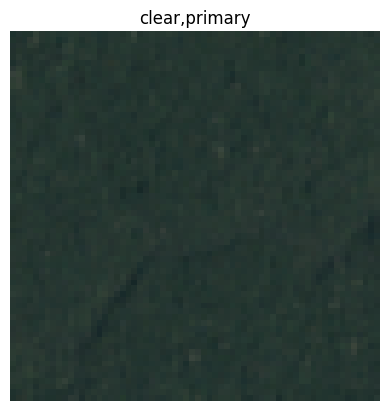

In [37]:
# Show a sample
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.manual_seed=100

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
# Denormalize the data
img_denormalized = denormalize(img)

# Transpose the image from (3, height, width) to (height, width, 3)
image_transposed = np.transpose(img_denormalized, (1, 2, 0))
image_transposed = np.clip(image_transposed, 0, 1)

plt.imshow(image_transposed)
#print(label)
title_name = ','.join([class_names_tags[index] for index, value in enumerate(label.tolist()) if value == 1]) # Set title according to label matrix and class_name_tags
#print(title_name)
plt.title(title_name)
plt.axis(False)
print(f"ImageSize: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")
print(','.join([str(index) + ': ' +class_names_tags[index] for index, value in enumerate(label.tolist()) if value == 1]))

### 4.3 Show several random samples

In this chapter we would like to print a several images form the train dataset to double check if the multi-label classification is associated correctly

* The number in the label of each image is the number in the image name. So we can touble check if we have loaded correct data together with the labels

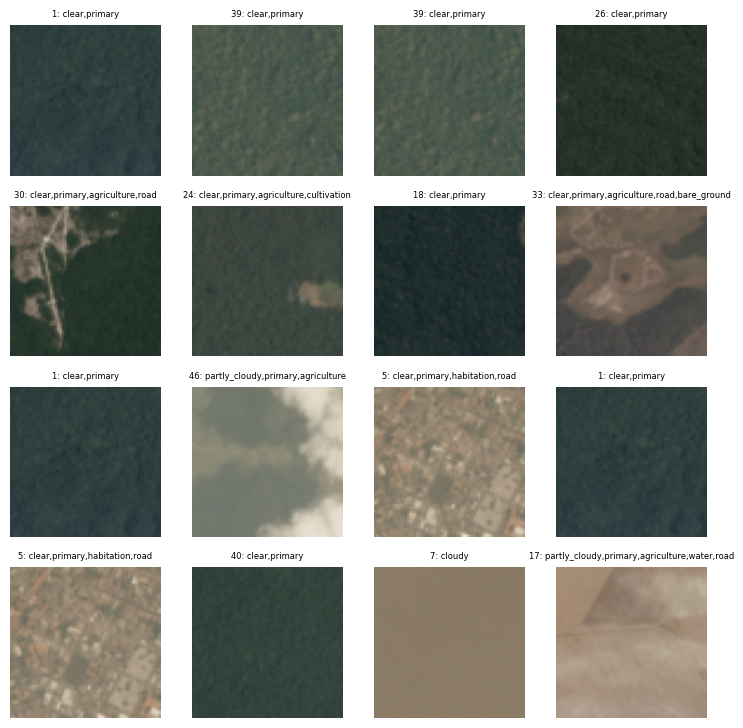

In [38]:
# Plot more images from a random selection
torch.manual_seed=40
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols +1):
  random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
  img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

# Transpose the image from (3, height, width) to (height, width, 3)
  img_denormalized = denormalize(img)
  image_transposed = np.transpose(img_denormalized, (1, 2, 0))
  image_transposed = np.clip(image_transposed, 0, 1)
  fig.add_subplot(rows,cols, i)
  plt.imshow(image_transposed)
  title_name = str(random_idx) +": "+ ','.join([class_names_tags[index] for index, value in enumerate(label.tolist()) if value == 1]) # Set title according to label matrix and class_name_tags
  plt.title(title_name, fontsize=6)
  plt.axis(False)




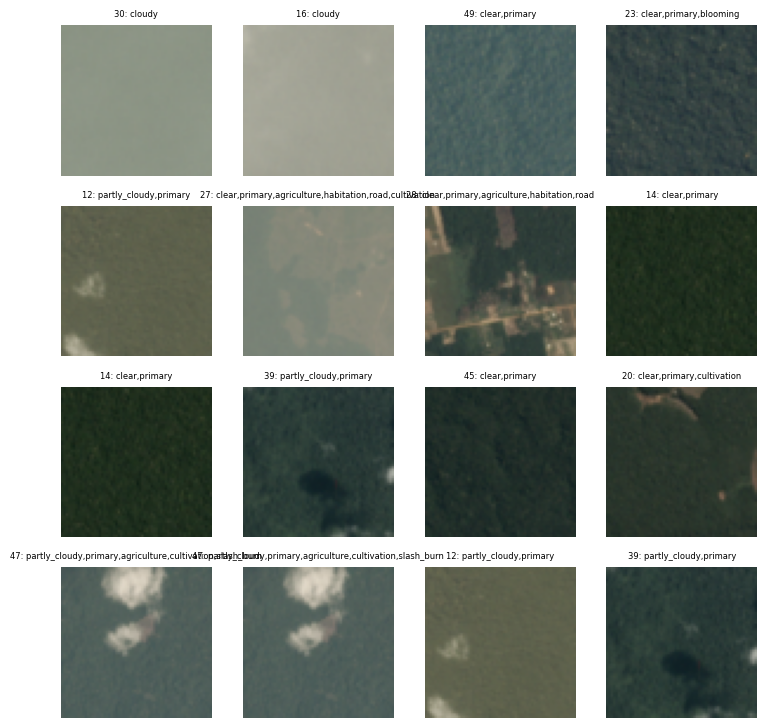

In [39]:
# Plot more images from a random selection from test dataset
torch.manual_seed=42
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols +1):
  random_idx = torch.randint(0, len(test_features_batch), size=[1]).item()
  img, label = test_features_batch[random_idx], test_labels_batch[random_idx]

# Transpose the image from (3, height, width) to (height, width, 3)
  img_denormalized = denormalize(img)
  image_transposed = np.transpose(img_denormalized, (1, 2, 0))
  image_transposed = np.clip(image_transposed, 0, 1)
  fig.add_subplot(rows,cols, i)
  plt.imshow(image_transposed)
  title_name = str(random_idx) +": "+ ','.join([class_names_tags[index] for index, value in enumerate(label.tolist()) if value == 1]) # Set title according to label matrix and class_name_tags
  plt.title(title_name, fontsize=6)
  plt.axis(False)



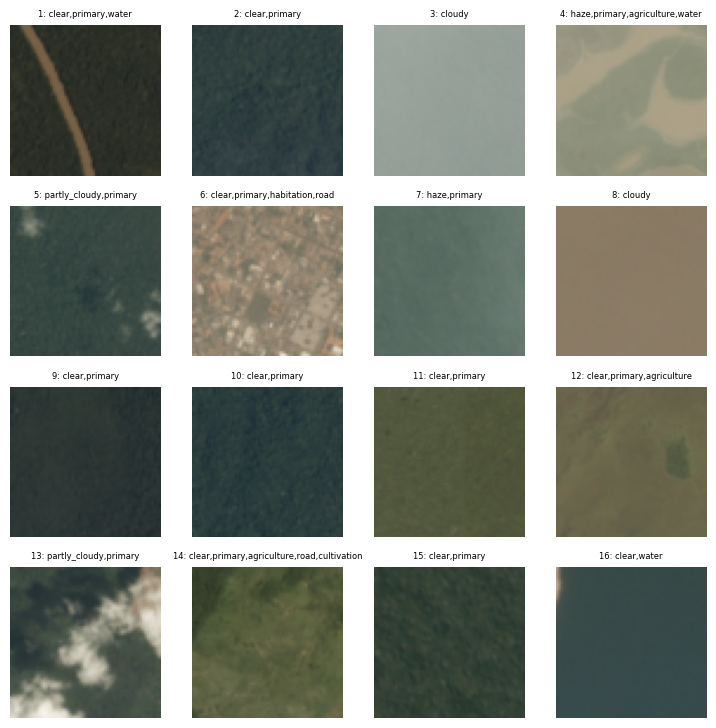

In [40]:
# Plot Images 0 - 9
# Plot more images
torch.manual_seed=40
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols +1):
  random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
  img, label = train_features_batch[i-1], train_labels_batch[i-1]
  # Transpose the image from (3, height, width) to (height, width, 3)
  img_denormalized = denormalize(img)
  image_transposed = np.transpose(img_denormalized, (1, 2, 0))
  image_transposed = np.clip(image_transposed, 0, 1)
  fig.add_subplot(rows,cols, i)
  plt.imshow(image_transposed)
  title_name = str(i) +": "+ ','.join([class_names_tags[index] for index, value in enumerate(label.tolist()) if value == 1]) # Set title according to label matrix and class_name_tags
  plt.title(title_name, fontsize=6)
  plt.axis(False)


## 5. Neural Network Base Model

--> First let us try to us a basic neural Network Model

Steps:
1. Define a model
2. Setup a Loss function --> For multi-label classification `BCEWithLogitsLoss` would be ideal --> see https://discuss.pytorch.org/t/using-bcewithlogisloss-for-multi-label-classification/67011
3. Setup an optimizer with the learning rate `LEARNIN_RATE_BASE_MODEL` --> Here we are using `torch.optim.Adam` optimizer, cluld be also replaced with ` torch.optim.SGD` but then you need also to increase the learning rate.
4. Setup a training Loop for the basemodel --> could be also reused for future models
5. Setup a testing Loop for the basemodel --> could be also reused for future models
6. Runn a Loop to train the Model the defined epochs
7. Plot the loss and the accuracy to review the loss history to detect overfitting or underfitting and to adjust the parameters or the number of epochs.

### 5.1 Define a base model
Here we define a base neural network with 2 Linear layers and an activation function with ReLu inbetween to also allow the model to handle nonlinear problems.

We initialise the model afterwards with the hyperparameter specified at the beginning of the file:

* Input shapes are the number of pixels --> `IMAGE_RESOLUTION_TRAIN_BASEMODEL` * `IMAGE_RESOLUTION_TRAIN_BASEMODEL` * colour channels.
* `HIDDEN_UNITS_BASEMODEL` for the number of units in the hidden layer
* Output layer is the len of our class_names_tags dictionary



In [41]:
from torch import nn

class LandscapeModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), #flatten inputs into a single vector
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )
  def forward(self,x:torch.Tensor):
    return self.layer_stack(x)




In [42]:
# Initialize the Neural Network ModelV0
#Create an instance of Module_1
torch.manual_seed = 42



model_1 = LandscapeModelV0(input_shape=(IMAGE_RESOLUTION_TRAIN_BASEMODEL * IMAGE_RESOLUTION_TRAIN_BASEMODEL * 3), # Input into Neural network need to match with the number of pixels --> resolution * colour channels
                                hidden_units=HIDDEN_UNITS_BASEMODEL,
                                output_shape=len(class_names_tags)).to(device) # send to GPU
next(model_1.parameters()).device
# Check if trained model already exists
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME_1
if os.path.exists(MODEL_SAVE_PATH):
  # Load in the saved model
  model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
  model_1.to(device)
  print('Model laoded from directory')


Model laoded from directory


In [ ]:
# Debug Code to test if I can fill data in the neural Network
#dummy_x = torch.rand([40,3,128,128])
#model_1(dummy_x)


### 5.2 Setup loss function and an optimizer
In this section we initialize the loss function for the model. We use here the `torch.optim.Adam` which is an  "Adaptive Moment Estimation" and Often the go-to optimizer because of its fast convergence.

We could also use the `torch.optim.SGD` because we have a large dataset but we will try with this one for the CNN Network.

The `LEARNIN_RATE_BASEMODEL` we have to set here quite small in comaprison to the `torch.optim.SGD`. --> At around 0.0001

This is the case because:
* `torch.optim.SGD` updates weights by a fixed learning rate and updates are uniform across all parameters
* `torch.optim.Adam` adapts the learning rate for each parameter based on estimates of the first (mean) and second (uncentered variance) moments of the gradients.




In [44]:
# Setup loss function and optimizer
LEARNIN_RATE_BASEMODEL = 0.00005
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=LEARNIN_RATE_BASEMODEL)



### 5.3 Functions for test loops:

We are creating a function for the following loops
* accuracy function `accuracy_fn` for multiclassification --> defined already in Section 1 for the general functions.
* training loop `train_step` function for iterating through the training dataset and the batches to train the model
* testing loop `test_step` function for iterating through the testing dataset and the batches to validate the model

In [45]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Is responsible for a training step with model tryinf to learn on dataloader"""

  train_loss, train_acc, score_f2 = 0, 0, 0
  #Put model into training mode
  model.train()

  #Add a loop to loop through the training batches
  for batch, (X, y) in tqdm(enumerate(data_loader), desc="Training Batches....."): # train dataloder has x number of batches, in every batch there are BATCHSiZE images with [batchnumber, clolor, height, weight]
    #PUt data on target device
    X, y = X.to(device) , y.to(device)

    # 1. Forward pass (outputs raw logits from the model)
    #print(X.shape)

    y_pred = model(X)
    #print(y_pred.shape)
    #2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss ## Accumulate training loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred) # go from logits --> prediction labels
    #Calculate F2 Score
    threshold = 0.5
    binary_test_pred = (y_pred > threshold).float()
    score_f2 += fbeta_score(y.cpu().numpy(), binary_test_pred.cpu().numpy(), beta=2, average="samples") * 100


    #3. Optimizer zero grad
    optimizer.zero_grad()

    #4. loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # # Print out what's happening
    # if batch % 400 == 0:
    #   print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  #Divide total train loss by lenght of the train dataloader
  score_f2 /= len(data_loader)
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.5f} | Train acc: {train_acc:.2f}% ")
  print(f"Test Score F-beata=2: {score_f2}% ")
  return train_loss, train_acc, score_f2

In [46]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):

   """Is responsible for a test step with model try inf to learn on dataloader"""
   test_loss, test_acc, score_f2 = 0,0,0

   # Put the model in eval mode
   model.eval()

   # Turn on inference mode
   with torch.inference_mode():

    for X, y in tqdm(data_loader, desc="Testing Batches....."):
      # Send data to the target device
      X, y = X.to(device) , y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred)
      # 3 Calculate F2 Score
      threshold = 0.5
      binary_test_pred = (test_pred > threshold).float()
      score_f2 += fbeta_score(y.cpu().numpy(), binary_test_pred.cpu().numpy(), beta=2, average="samples") * 100



    score_f2 /= len(data_loader)
    #Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Testloss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")
    print(f"Test Score F-beata=2: {score_f2}%")
    return test_loss, test_acc, score_f2

### 5.5 Run training loop with loop fucntions

In this chapter we are running a whole training and validation for our first base neural network model. All hyperparameters are defined in the beginning and shown before the training loop is starting:

In [ ]:
# Training loop:
# Set Reuslts Dictionary
results_model_01 = { "train_loss": [],
                    "train_accuracy" : [],
                    "test_loss": [],
                    "test_accuracy" : [],
                    "train_score": [],
                    "test_score" : []
}

# Show Hyperparameter to user:
print("Model 1 will be trained with the folowing parameters:")
print(f"The parameter HIDDEN_UNITS_BASEMODEL is set to: {HIDDEN_UNITS_BASEMODEL}")
print(f"The parameter LEARNIN_RATE_BASEMODEL is set to: {LEARNIN_RATE_BASEMODEL}")
print(f"The parameter EPOCHS_BASEMODEL is set to: {EPOCHS_BASEMODEL}")

print("For the dataset we have used the folowing parameters: ")
print(f"BATCH_SIZE is set to: {BATCH_SIZE}")
print(f"IMAGE_RESOLUTION_TRAIN is set to: {IMAGE_RESOLUTION_TRAIN_BASEMODEL} * {IMAGE_RESOLUTION_TRAIN_BASEMODEL}")
print(f"TEST_SIZE is set to: {TEST_SIZE}")

torch.manual_seed = 42

#Measure time for execution
from timeit import default_timer as timer
# import tqdm for progress bar
from tqdm.auto import tqdm

#Set the seed and start the timer
torch.manual_seed = 42
train_time_start_on_gpu = timer()

# Create training and test  loop
for epoch in tqdm(range(EPOCHS_BASEMODEL),desc="Running epochs Batches....."):

  print(f"Epoch: {epoch} \n-----")
  train_loss, train_accuracy, train_score = train_step(model=model_1,
                                            data_loader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            accuracy_fn=accuracy_fn,
                                            device=device)
  test_loss, test_accuracy, test_score = test_step(model=model_1,
                                            data_loader=test_dataloader,
                                            loss_fn=loss_fn,
                                            accuracy_fn=accuracy_fn,
                                            device=device)
  # Update results dictionary
  results_model_01["train_loss"].append(train_loss.detach().cpu().numpy())
  results_model_01["train_accuracy"].append(train_accuracy)
  results_model_01["test_loss"].append(test_loss.detach().cpu().numpy())
  results_model_01["test_accuracy"].append(test_accuracy)
  results_model_01['train_score'].append(train_score)
  results_model_01['test_score'].append(test_score)

train_time_end_on_gpu = timer()
total_train_time_model_1 = show_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

Model 1 will be trained with the folowing parameters:
The parameter HIDDEN_UNITS_BASEMODEL is set to: 100
The parameter LEARNIN_RATE_BASEMODEL is set to: 5e-05
The parameter EPOCHS_BASEMODEL is set to: 4
For the dataset we have used the folowing parameters: 
BATCH_SIZE is set to: 50
IMAGE_RESOLUTION_TRAIN is set to: 64 * 64
TEST_SIZE is set to: 0.2


Running epochs Batches.....:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0 
-----


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.66290 | Train acc: 87.93% 
Test Score F-beata=2: 37.215599350607846% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.66181 | Test acc: 88.20%
Test Score F-beata=2: 38.69097630436263%
Epoch: 1 
-----


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.66082 | Train acc: 88.25% 
Test Score F-beata=2: 39.525199821539566% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.66127 | Test acc: 88.31%
Test Score F-beata=2: 39.514498991267004%
Epoch: 2 
-----


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.66029 | Train acc: 88.35% 
Test Score F-beata=2: 40.142905071822156% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.66101 | Test acc: 88.35%
Test Score F-beata=2: 39.863585818660894%
Epoch: 3 
-----


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.64983 | Train acc: 90.77% 
Test Score F-beata=2: 57.758741903595826% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.64701 | Test acc: 91.41%
Test Score F-beata=2: 61.85704331409717%
Train time on cuda: 293.433 seconds


### 5.6 Plot the loss and the accuracy for detecting overfitting or underfitting

The plot shows if the model is running into an overfitting or an underfitting issue. This should be a help to find out the correct amount of epochs on which you want to train the model.

As a help to analyse the two machine learning behaviors when training models:
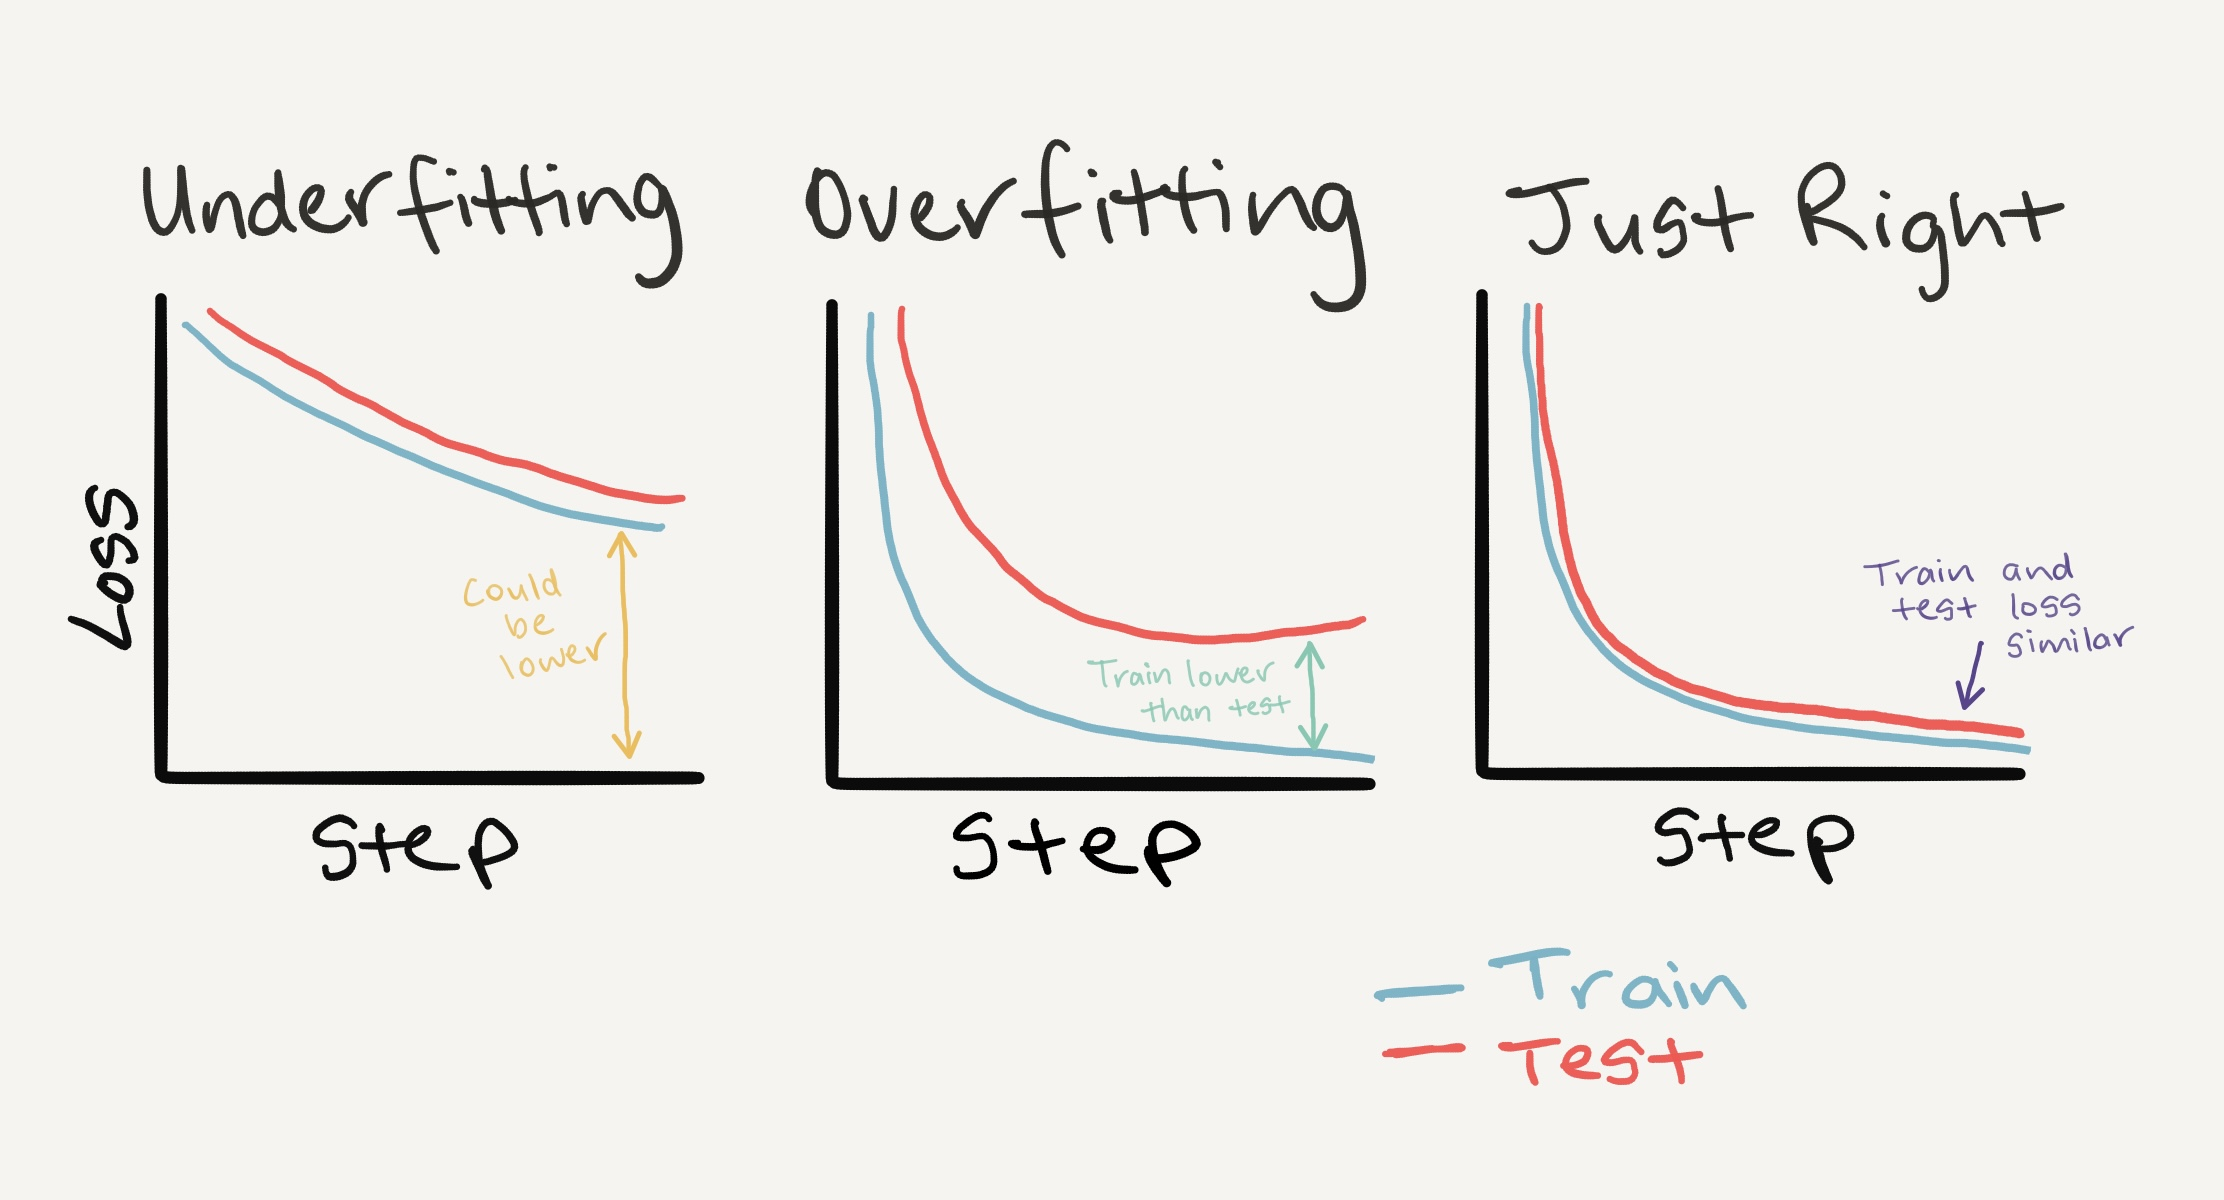

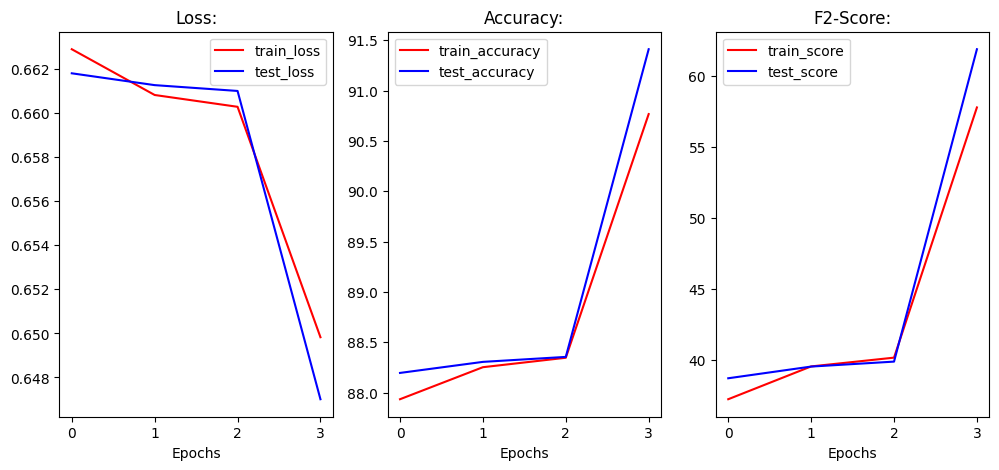

In [ ]:
# Show Loss and Accuracy Plot
plot_loss_values(results_model_01)

In [47]:
# Get model_1 results
model_1_results = model_rating(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

  0%|          | 0/162 [00:00<?, ?it/s]

{'model_name': 'LandscapeModelV0',
 'model_loss': 0.647013247013092,
 'model_acc': 91.41040699693727,
 'model_score': 61.85704331409717}

## 6. Convolutional neural Network:

In this chapter, we gona improve our base neural network by using another apporoach for a neural network, namley a convolutional neural network, shortly CNN. This should improve the accuracy up to 90% and more by using convolutional layers in the neural network.





### 6.1 Setup CNN network

We are using as a CNN model the folowing architecture:

Architektur:
* Input Layer
3x convolutioonal block with:
  * Convolutional Layer
  * Hidden activation/non-linear activation
  * Pooling layer
* Output layer/linear layer


As a basis to understand the CNN Network we used the CNN explainer website https://poloclub.github.io/cnn-explainer/ and  builded a  model according to that

In [48]:
from torch.nn.modules.pooling import MaxPool2d
# Create a CNN model
class LandscapeModelV1(nn.Module):
  """
 Here we are using a Model architecture according to  TinyVGG model
 from CNN explainer website https://poloclub.github.io/cnn-explainer/
  """

  def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=KERNEL_CNN_NETWORK,
                  stride=STRIDE_CNN_NETWORK,
                  padding=PADDING_CNN_NETWORK
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=KERNEL_CNN_NETWORK,
                  stride=STRIDE_CNN_NETWORK,
                  padding=PADDING_CNN_NETWORK
                  ),
        nn.ReLU(),
        nn.MaxPool2d( kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=KERNEL_CNN_NETWORK,
                stride=STRIDE_CNN_NETWORK,
                padding=PADDING_CNN_NETWORK
                ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=KERNEL_CNN_NETWORK,
                stride=STRIDE_CNN_NETWORK,
                padding=PADDING_CNN_NETWORK
                ),
        nn.ReLU(),
        nn.MaxPool2d( kernel_size=2)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=KERNEL_CNN_NETWORK,
                stride=STRIDE_CNN_NETWORK,
                padding=PADDING_CNN_NETWORK
                ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=KERNEL_CNN_NETWORK,
                stride=STRIDE_CNN_NETWORK,
                padding=PADDING_CNN_NETWORK
                ),
        nn.ReLU(),
        nn.MaxPool2d( kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*28*28,
                  out_features=output_shape)

    )


  def forward(self, x):
    # Debug comment in the blocks with the print for checking out the different shapes in the layers to define the in_features for the final nn.Lienar Layer
    x= self.conv_block_1(x)
    #print(f"Output block of conv_blick_1: {x.shape}")
    x= self.conv_block_2(x)
    #print(f"Output block of conv_blick_2: {x.shape}")
    x= self.conv_block_3(x)
    #print(f"Output block of conv_blick_3: {x.shape}")
    x = self.classifier(x)
    #print(f"Output block of classifier: {x.shape}")
    return x


### 6.2 Intitalize model

Here we would like to initialize teh new CNN model and the according parameters:

* `input_shape` is  here three because we would like to split it up to the three colour channels
* `hidden_units` is set to the hyperparameter `HIDDEN_UNITS_CNN` defined in thebeginning

In [49]:
torch.manual_seed = 42
model_2 = LandscapeModelV1(input_shape=3,
                              hidden_units=HIDDEN_UNITS_CNN,
                              output_shape=len(class_names_tags)).to(device) # send to GPU
# Check if trained model already exists
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME_2
if os.path.exists(MODEL_SAVE_PATH):
  # Load in the saved model
  model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
  model_2.to(device)
  print('Model laoded from directory')

Model laoded from directory


In [51]:
# Debug to find out Number of hidden unit in CNN
rand_image_tensor = torch.randn(size=(3,IMAGE_RESOLUTION_TRAIN_RESNET,IMAGE_RESOLUTION_TRAIN_RESNET))
print(rand_image_tensor.shape)
model_2(rand_image_tensor.unsqueeze(0).to(device))

torch.Size([3, 224, 224])


tensor([[-21.5811,  -8.9580,  12.5983, -18.1989,   1.6696,   2.3677, -16.1149,
           8.6003,   9.2703, -12.7923, -21.1753, -10.4254,   1.0433,  -8.4353,
         -27.8641, -23.1140, -23.6175]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

### 6.3 Setup optimizer and loss function

In this section we initialize the loss function for the model. We use here the `torch.optim.SGD` which is an  "Adaptive Moment Estimation" and Often the go-to optimizer because of its fast convergence.

We could also use the `torch.optim.Addam` because we have a large dataset but we will try with this one for the CNN Network.

The `LEARNIN_RATE_CNN` we have to set here rather big in comaprison to the `torch.optim.Adam`. --> At around 0.1 - 0.01

This is the case because:
* `torch.optim.SGD` updates weights by a fixed learning rate and updates are uniform across all parameters
* `torch.optim.Adam` adapts the learning rate for each parameter based on estimates of the first (mean) and second (uncentered variance) moments of the gradients.

In [50]:
from torch.nn.modules.loss import CrossEntropyLoss
# Setup loss function / eval mectric soptimizer
LEARNIN_RATE_CNN = 0.5
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=LEARNIN_RATE_CNN)

###6.4 Using the model in a training Loop

All hyperparameters are defined in the beginning and shown before the training loop is starting

We are using the predefined and the same methods for the training and testing loop from the base model:

* `train_step`
* `test_step`

In [ ]:
torch.manual_seed = 42
torch.cuda.manual_seed(42)

# Set Reuslts Dictionary
results_model_02 = { "train_loss": [],
            "train_accuracy" : [],
            "test_loss": [],
            "test_accuracy" : [],
            "train_score": [],
            "test_score" : []
}


# Show Hyperparameter to user:
print("Model 2 will be trained with the folowing parameters:")
print(f"The parameter PADDING_CNN_NETWORK is set to: {PADDING_CNN_NETWORK}")
print(f"The parameter STRIDE_CNN_NETWORK is set to: {STRIDE_CNN_NETWORK}")
print(f"The parameter KERNEL_CNN_NETWORK is set to: {KERNEL_CNN_NETWORK}")
print(f"The parameter HIDDEN_UNITS_CNN is set to: {HIDDEN_UNITS_CNN}")
print(f"The parameter LEARNIN_RATE_CNN is set to: {LEARNIN_RATE_CNN}")
print(f"The parameter EPOCHS_CNN is set to: {EPOCHS_CNN}")

print("For the dataset we have used the folowing parameters: ")
print(f"BATCH_SIZE is set to: {BATCH_SIZE}")
print(f"IMAGE_RESOLUTION_TRAIN is set to: {IMAGE_RESOLUTION_TRAIN_RESNET} * {IMAGE_RESOLUTION_TRAIN_RESNET}")
print(f"TEST_SIZE is set to: {TEST_SIZE}")

#measure Time
from timeit import default_timer as timer
train_time_start_model_2 = timer()


for epoch in tqdm(range(EPOCHS_CNN)):
  print(f"Epoch: {epoch} \n---------------")
  train_loss, train_accuracy, train_score = train_step(model=model_2,
                                            data_loader=train_dataloader_cnn,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            accuracy_fn=accuracy_fn,
                                            device=device)
  test_loss, test_accuracy, test_score = test_step(model=model_2,
                                            data_loader=test_dataloader_cnn,
                                            loss_fn=loss_fn,
                                            accuracy_fn=accuracy_fn,
                                            device=device)

  # Update results dictionary
  results_model_02["train_loss"].append(train_loss.detach().cpu().numpy())
  results_model_02["train_accuracy"].append(train_accuracy)
  results_model_02["test_loss"].append(test_loss.detach().cpu().numpy())
  results_model_02["test_accuracy"].append(test_accuracy)
  results_model_02["train_score"].append(train_score)
  results_model_02["test_score"].append(test_score)

  train_time_end_model_2 = timer()
  total_train_time_model_2 = show_train_time(start=train_time_start_model_2, end=train_time_end_model_2)

Model 2 will be trained with the folowing parameters:
The parameter PADDING_CNN_NETWORK is set to: 1
The parameter STRIDE_CNN_NETWORK is set to: 1
The parameter KERNEL_CNN_NETWORK is set to: 3
The parameter HIDDEN_UNITS_CNN is set to: 100
The parameter LEARNIN_RATE_CNN is set to: 0.5
The parameter EPOCHS_CNN is set to: 10
For the dataset we have used the folowing parameters: 
BATCH_SIZE is set to: 50
IMAGE_RESOLUTION_TRAIN is set to: 224 * 224
TEST_SIZE is set to: 0.2


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 
---------------


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.23647 | Train acc: 91.04% 
Test Score F-beata=2: 63.15617133265667% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.21350 | Test acc: 91.90%
Test Score F-beata=2: 68.81597503563576%
Train time on None: 471.340 seconds
Epoch: 1 
---------------


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.21351 | Train acc: 91.64% 
Test Score F-beata=2: 66.37897719122432% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.19744 | Test acc: 92.56%
Test Score F-beata=2: 71.34932933684331%
Train time on None: 940.404 seconds
Epoch: 2 
---------------


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.18727 | Train acc: 92.67% 
Test Score F-beata=2: 70.82338462814855% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.18414 | Test acc: 93.15%
Test Score F-beata=2: 74.22859611468209%
Train time on None: 1408.533 seconds
Epoch: 3 
---------------


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.17954 | Train acc: 93.02% 
Test Score F-beata=2: 72.35541440671105% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.19200 | Test acc: 93.20%
Test Score F-beata=2: 74.54410829725703%
Train time on None: 1875.134 seconds
Epoch: 4 
---------------


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.16896 | Train acc: 93.44% 
Test Score F-beata=2: 74.23823388736825% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.18110 | Test acc: 93.42%
Test Score F-beata=2: 75.05259173503126%
Train time on None: 2341.385 seconds
Epoch: 5 
---------------


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.15786 | Train acc: 93.87% 
Test Score F-beata=2: 76.14942042591824% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.17720 | Test acc: 93.60%
Test Score F-beata=2: 76.0687235513799%
Train time on None: 2807.705 seconds
Epoch: 6 
---------------


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.14619 | Train acc: 94.32% 
Test Score F-beata=2: 77.9171530357883% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.18238 | Test acc: 93.65%
Test Score F-beata=2: 76.71480025669054%
Train time on None: 3275.047 seconds
Epoch: 7 
---------------


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.13245 | Train acc: 94.92% 
Test Score F-beata=2: 80.17051041605563% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.19392 | Test acc: 93.67%
Test Score F-beata=2: 78.06846910579557%
Train time on None: 3741.736 seconds
Epoch: 8 
---------------


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.11988 | Train acc: 95.43% 
Test Score F-beata=2: 81.98064913001136% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.21894 | Test acc: 93.31%
Test Score F-beata=2: 77.3811039373665%
Train time on None: 4208.943 seconds
Epoch: 9 
---------------


Training Batches.....: 0it [00:00, ?it/s]

Train Loss: 0.11308 | Train acc: 95.76% 
Test Score F-beata=2: 82.90558101685241% 


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Testloss: 0.23862 | Test acc: 93.53%
Test Score F-beata=2: 79.65978308041574%
Train time on None: 4675.610 seconds


### 6.5 Plot the loss and the accuracy for detecting overfitting or underfitting
The plot shows if the model is running into an overfitting or an underfitting issue. This should be a help to find out the correct amount of epochs on which you want to train the model.


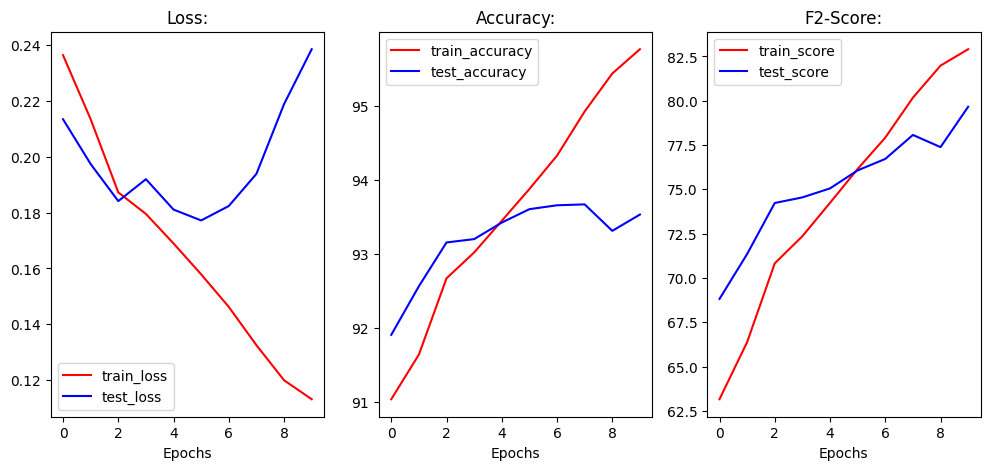

In [ ]:
# Show Loss and Accuracy Plot for model 2
plot_loss_values(results_model_02)

In [52]:
# Get model_2 results
model_2_results = model_rating(
    model=model_2,
    data_loader=test_dataloader_cnn,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_2_results

  0%|          | 0/162 [00:00<?, ?it/s]

{'model_name': 'LandscapeModelV1',
 'model_loss': 0.23861674964427948,
 'model_acc': 93.52811720501407,
 'model_score': 79.65978308041574}

## 7. Using pretrained Model from Pytorch Library

As a third approach for using neural networks, we try to use a predefined model from the pytorch library and train the mode based on our dataset. There we expect a larger training time because the model would be designed more complex

### 7.1 Set up pretrained model

* Here we set up the model from the `torchvision.models` library.
* The attribute `pretrained=True` enables us to use pretrained weights and we are just doing the specific training for our data.
* By the reason this is a multi-label classification, we need to define also the amount of classes we have to the model.
* We use as loss function alos the BCEWithLogitsLoss as before
* As an optimizer, we use also the SGD optimizer which we have already used for the CNN model.



In [53]:
# Import for this section
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


#Model setup
model_3 = models.resnet18(pretrained=True)
#Modify the last fully connected layer for multi-label classification
model_3.fc = nn.Linear(model_3.fc.in_features, 17)

## Debug efficientnet_b7 model
# model_3 = timm.create_model('tf_efficientnet_b7_ns', pretrained=True)
# model_3.classifier = nn.Linear(model_3.classifier.in_features, 17)

## Debug vgg16 model
# # Model setup
# model_3 = models.vgg16(pretrained=True)
# # Modify the last layer for multi-label classification
# model_3.classifier[6] = nn.Linear(model_3.classifier[6].in_features, 17)
LEARNIN_RATE_CNN_PRETRAINED = 0.015
EPOCHS_CNN_PRETRAINED = 5

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=LEARNIN_RATE_CNN_PRETRAINED, momentum=0.9)
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME_3
if os.path.exists(MODEL_SAVE_PATH):
  # Load in the saved model
  model_3.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
  model_3.to(device)
  print('Model laoded from directory')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


Model laoded from directory


### 7.2 Training Loop for predefined model

Here we loop through all epochs to finally train the predefined model to our data. All hyperparameters are defined in the beginning and shown before the training loop is starting

In [ ]:
# Train the model

# Show Hyperparameter to user:
print("Model 3 will be trained with the folowing parameters:")
print(f"The parameter LEARNIN_RATE_Pytorch is set to: {LEARNIN_RATE_Pytorch}")
print(f"The parameter EPOCHS_Pytorch  is set to: {EPOCHS_Pytorch }")

print("For the dataset we have used the folowing parameters: ")
print(f"BATCH_SIZE is set to: {BATCH_SIZE}")
print(f"IMAGE_RESOLUTION_TRAIN_RESNET is set to: {IMAGE_RESOLUTION_TRAIN_RESNET} * {IMAGE_RESOLUTION_TRAIN_RESNET}")
print(f"TEST_SIZE is set to: {TEST_SIZE}")

results_model_03 = { "train_loss": [],
            "train_accuracy" : [],
            "test_loss": [],
            "test_accuracy" : [],
            "train_score": [],
            "test_score" : []
}

#measure Time
from timeit import default_timer as timer
train_time_start_model_3 = timer()
EPOCHS_Pytorch = 15
model_3 = model_3.to(device)
for epoch in range(EPOCHS_CNN_PRETRAINED):
    model_3.train()
    train_running_loss = 0.0
    train_score_val = 0
    correct = 0
    total = 0
    for inputs, targets in tqdm(train_dataloader_cnn, desc="Training Batches....."):
        # Assuming targets are already encoded for each class
        # targets shape should be (batch_size, num_classes)

        inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU

        optimizer.zero_grad()

        outputs = model_3(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total += targets.size(0)
        train_running_loss += loss.item()
        predicted = torch.sigmoid(outputs).data > 0.5
        correct += (predicted == targets).sum().item()
        train_score_val += fbeta_score(targets.cpu().numpy(), predicted.cpu().numpy(), beta=2, average="samples") * 100

    train_score_val /= len(train_dataloader_cnn)
    train_accuracy = 100 * correct / (total * 17)
    print(f'Train Accuracy: {train_accuracy:.2f}%')
    print(f'Train F-2 Score: {train_score_val:.2f}%')
    print(f'Epoch [{epoch+1}/{EPOCHS_CNN_PRETRAINED}], Loss: {train_running_loss/len(train_dataloader_cnn):.4f}')

    # Validate the model
    model_3.eval()
    total = 0
    correct = 0
    test_score_val = 0
    test_running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader_cnn, desc="Testing Batches....."):
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU

            outputs = model_3(inputs)
            predicted = torch.sigmoid(outputs).data > 0.5
            total += targets.size(0)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item()
            correct += (predicted == targets).sum().item()
            test_score_val += fbeta_score(targets.cpu().numpy(), predicted.cpu().numpy(), beta=2, average="samples") * 100

    test_score_val /= len(test_dataloader_cnn)
    test_accuracy = 100 * correct / (total * 17)
    print(f'Loss: {test_running_loss/len(test_dataloader_cnn):.4f}')
    print(f'Validation Accuracy: {test_accuracy:.2f}%')
    print(f'Validation F-2 Score: {test_score_val:.2f}%')
    # Update results dictionary
    results_model_03["train_loss"].append(train_running_loss/len(train_dataloader_cnn))
    results_model_03["train_accuracy"].append(train_accuracy)
    results_model_03["test_loss"].append(test_running_loss/len(test_dataloader_cnn))
    results_model_03["test_accuracy"].append(test_accuracy)
    results_model_03["train_score"].append(train_score_val)
    results_model_03["test_score"].append(test_score_val)

train_time_end_model_3 = timer()
total_train_time_model_3 = show_train_time(start=train_time_start_model_3, end=train_time_end_model_3)
print('Training complete')

Model 3 will be trained with the folowing parameters:
The parameter LEARNIN_RATE_Pytorch is set to: 0.001
The parameter EPOCHS_Pytorch  is set to: 15
For the dataset we have used the folowing parameters: 
BATCH_SIZE is set to: 50
IMAGE_RESOLUTION_TRAIN_RESNET is set to: 224 * 224
TEST_SIZE is set to: 0.2


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Train Accuracy: 95.23%
Train F-2 Score: 84.40%
Epoch [1/5], Loss: 0.1251


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Loss: 0.0978
Validation Accuracy: 96.32%
Validation F-2 Score: 88.91%


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Train Accuracy: 96.42%
Train F-2 Score: 88.82%
Epoch [2/5], Loss: 0.0938


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Loss: 0.0935
Validation Accuracy: 96.50%
Validation F-2 Score: 89.63%


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Train Accuracy: 96.90%
Train F-2 Score: 90.33%
Epoch [3/5], Loss: 0.0814


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Loss: 0.0944
Validation Accuracy: 96.49%
Validation F-2 Score: 89.86%


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Train Accuracy: 97.41%
Train F-2 Score: 91.89%
Epoch [4/5], Loss: 0.0691


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Loss: 0.0993
Validation Accuracy: 96.41%
Validation F-2 Score: 89.93%


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Train Accuracy: 97.94%
Train F-2 Score: 93.45%
Epoch [5/5], Loss: 0.0564


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Loss: 0.1077
Validation Accuracy: 96.22%
Validation F-2 Score: 89.79%
Train time on None: 1051.085 seconds
Training complete


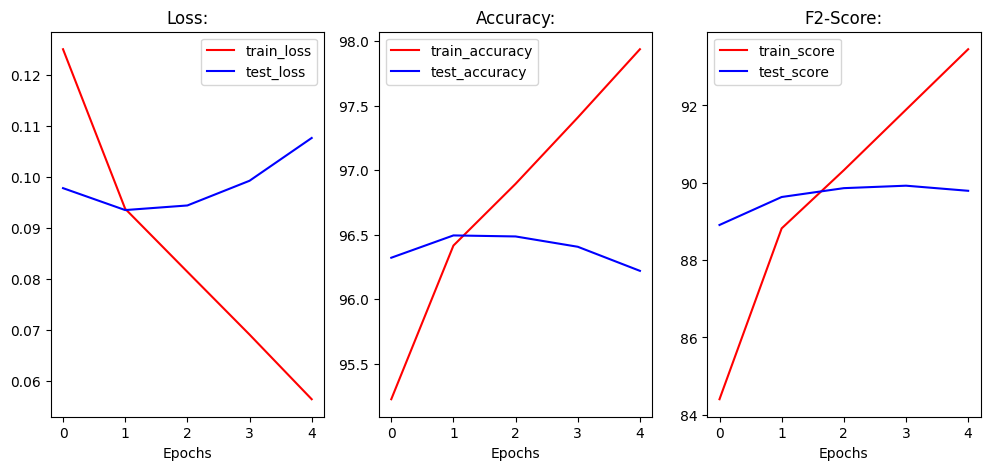

In [ ]:
# Show Loss and Accuracy Plot for model 3
plot_loss_values(results_model_03)

In [54]:
# Get model_3 results
model_3_results = model_rating(
    model=model_3,
    data_loader=test_dataloader_cnn,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_3_results

  0%|          | 0/162 [00:00<?, ?it/s]

{'model_name': 'ResNet',
 'model_loss': 0.11024412512779236,
 'model_acc': 96.19882542388937,
 'model_score': 88.23176316166659}



## 8. Testing another approach with splitting up the dataset to improve results

In this chapter, we would like to improve our previous approach with a  pretrained cnn model by splitting up the labels into two separate models.

### 8.1 Setting up the Dataset

In this chapter we are splitting up the dataset into two set of labels. We recognized in the random forest jupyter notebook, that there is normaly always one weather label per image and some additional labels for categorizing the picture more in detail.

* Therefore we use `weather_labels` to define 4 labels in a multiclass problem with 4 labels.
* We use the `other_labels` to define a multi-label classification problem with 13 labels

We need to do the following steps:
1.  Define the arrays where the labels are splitte up
2. Use old dataset as a base for the new one
3. Check if the old dataset is having in every label just one weather tag
4. Splitting it up into two columns according to the two subset of labels
5. Adding columns with the index of the labels (weather label and other labels)
6. Setting up a dataset based on train and test data for the weather labels
7. Create a pytorch dataloader for the weather labels
8. Setting up a dataset based on train and test data for the other labels
9. Create a pytorch dataloader for the other labels
10. Check if shuffeling of the two dataset is the same, show random sample an plot it from both datasets

In [55]:
# Define the arrays where the labels are splitte up
weather_labels = ["cloudy", "partly_cloudy", "clear", "haze"]
other_labels = ["primary", "agriculture", "water", "habitation", "road", "cultivation", "slash_burn", "conventional_mine", "bare_ground", "artisinal_mine", "blooming", "selective_logging", "blow_down"]

In [56]:
# Create dataset for this section based on the dataset before
df = df_labels_train.copy(deep=True)

In [57]:
# Check if each row contains exactly one of the labels
rows_with_one_required_label = df['tags'].apply(lambda x: sum(label in x for label in weather_labels) == 1)

# Check if all rows contain exactly one of the labels
all_rows_contain_one_label = rows_with_one_required_label.all()

print(f"All rows contain exactly one label: {all_rows_contain_one_label}")

# Filter rows where more than one of the specified labels are present
indices_with_multiple_required_labels = rows_with_one_required_label[rows_with_one_required_label == False].index

# Display the filtered rows
print(df.loc[indices_with_multiple_required_labels])

All rows contain exactly one label: False
            image_name     tags  \
24448  train_24448.jpg  [water]   

                                       labels_vectorized  
24448  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  


In [58]:
# Function to extract weather tags
def extract_weather_tags(tags):
    weather_tag = [tag for tag in tags if tag in weather_labels]
    return weather_tag[0] if weather_tag else None

# Extracting the weather tags for each row
df['weather_tags'] = df['tags'].apply(extract_weather_tags)

# If there are rows with missing weather tags, fill them with them with clear
if df['weather_tags'].isnull().any():
    df['weather_tags'].fillna('clear', inplace=True)
    print("Missing weather tags were filled with 'clear'.")

# Extracting the other tags for each row (excluding the weather tag)
df['other_tags'] = df['tags'].apply(lambda x: [tag for tag in x if tag not in weather_labels])

df.head(10)

Missing weather tags were filled with 'clear'.


image_name                                               tags  \
0  train_0.jpg                                    [haze, primary]   
1  train_1.jpg               [agriculture, clear, primary, water]   
2  train_2.jpg                                   [clear, primary]   
3  train_3.jpg                                   [clear, primary]   
4  train_4.jpg    [agriculture, clear, habitation, primary, road]   
5  train_5.jpg                             [haze, primary, water]   
6  train_6.jpg  [agriculture, clear, cultivation, primary, water]   
7  train_7.jpg                                    [haze, primary]   
8  train_8.jpg         [agriculture, clear, cultivation, primary]   
9  train_9.jpg   [agriculture, clear, cultivation, primary, road]   

                                   labels_vectorized weather_tags  \
0  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         haze   
1  [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...        clear   
2  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        clear   
3  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        clear   
4  [0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...        clear   
5  [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...         haze   
6  [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...        clear   
7  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         haze   
8  [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...        clear   
9  [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...        clear   

                                   other_tags  
0                                   [primary]  
1               [agriculture, primary, water]  
2                                   [primary]  
3                                   [primary]  
4    [agriculture, habitation, primary, road]  
5                            [primary, water]  
6  [agriculture, cultivation, primary, water]  
7                                   [primary]  
8         [agriculture, cultivation, primary]  
9   [agriculture, cultivation, primary, road]

In [59]:
# Getting the index for the multiclass label
df['index_wheather_tags'] = df['weather_tags'].apply(lambda x: weather_labels.index(x) if x in weather_labels else None)
df.head(10)

image_name                                               tags  \
0  train_0.jpg                                    [haze, primary]   
1  train_1.jpg               [agriculture, clear, primary, water]   
2  train_2.jpg                                   [clear, primary]   
3  train_3.jpg                                   [clear, primary]   
4  train_4.jpg    [agriculture, clear, habitation, primary, road]   
5  train_5.jpg                             [haze, primary, water]   
6  train_6.jpg  [agriculture, clear, cultivation, primary, water]   
7  train_7.jpg                                    [haze, primary]   
8  train_8.jpg         [agriculture, clear, cultivation, primary]   
9  train_9.jpg   [agriculture, clear, cultivation, primary, road]   

                                   labels_vectorized weather_tags  \
0  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         haze   
1  [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...        clear   
2  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        clear   
3  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        clear   
4  [0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...        clear   
5  [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...         haze   
6  [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...        clear   
7  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         haze   
8  [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...        clear   
9  [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...        clear   

                                   other_tags  index_wheather_tags  
0                                   [primary]                    3  
1               [agriculture, primary, water]                    2  
2                                   [primary]                    2  
3                                   [primary]                    2  
4    [agriculture, habitation, primary, road]                    2  
5                            [primary, water]                    3  
6  [agriculture, cultivation, primary, water]                    2  
7                                   [primary]                    3  
8         [agriculture, cultivation, primary]                    2  
9   [agriculture, cultivation, primary, road]                    2

In [60]:
# 2.5 transfer label data into vectorized data for multi-label classification for weather tag
from sklearn.preprocessing import MultiLabelBinarizer

# Instantiate multiclass classification
multi_label_binary = MultiLabelBinarizer(classes=other_labels)
label_matrix_train_2 = multi_label_binary.fit_transform(df['other_tags'])
# Convert the matrix to float
label_matrix_train_2 = label_matrix_train_2.astype(np.float32)
label_matrix_train_2


df['other_tags_vectorized'] = ['['+', '.join(map(str, row)) + ']' for row in label_matrix_train_2.astype(int)]
df.head(10)

image_name                                               tags  \
0  train_0.jpg                                    [haze, primary]   
1  train_1.jpg               [agriculture, clear, primary, water]   
2  train_2.jpg                                   [clear, primary]   
3  train_3.jpg                                   [clear, primary]   
4  train_4.jpg    [agriculture, clear, habitation, primary, road]   
5  train_5.jpg                             [haze, primary, water]   
6  train_6.jpg  [agriculture, clear, cultivation, primary, water]   
7  train_7.jpg                                    [haze, primary]   
8  train_8.jpg         [agriculture, clear, cultivation, primary]   
9  train_9.jpg   [agriculture, clear, cultivation, primary, road]   

                                   labels_vectorized weather_tags  \
0  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         haze   
1  [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...        clear   
2  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        clear   
3  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        clear   
4  [0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...        clear   
5  [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...         haze   
6  [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...        clear   
7  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         haze   
8  [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...        clear   
9  [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...        clear   

                                   other_tags  index_wheather_tags  \
0                                   [primary]                    3   
1               [agriculture, primary, water]                    2   
2                                   [primary]                    2   
3                                   [primary]                    2   
4    [agriculture, habitation, primary, road]                    2   
5                            [primary, water]                    3   
6  [agriculture, cultivation, primary, water]                    2   
7                                   [primary]                    3   
8         [agriculture, cultivation, primary]                    2   
9   [agriculture, cultivation, primary, road]                    2   

                     other_tags_vectorized  
0  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
2  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
3  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
4  [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
5  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
6  [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  
7  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
8  [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  
9  [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

In [61]:
# 3.3 Split data into training and test data for dataset one
from sklearn.model_selection import train_test_split

# Splitting the DataFrame into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# 3.4 Create Custom Dataset object for dataset one
dataset_train_1 = CustomImageDataset(img_dir_x_train, train_df,train_df['index_wheather_tags'].values,  transform=transform_resnet)
dataset_test_1 =  CustomImageDataset(img_dir_x_train, test_df,test_df['index_wheather_tags'].values, transform=transform_resnet)

# 3.5 Load Data into a Pytorch Dataset Object for dataset one
from torch.utils.data import DataLoader
print(f"Dataset with Batchsize {BATCH_SIZE} will be created")

train_dataloader_1 = DataLoader(dataset=dataset_train_1,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
test_dataloader_1 = DataLoader(dataset=dataset_test_1,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader_1, test_dataloader_1

Dataset with Batchsize 50 will be created


(<torch.utils.data.dataloader.DataLoader at 0x7c393c2a4490>,
 <torch.utils.data.dataloader.DataLoader at 0x7c393c2a5fc0>)

In [62]:
# Check out what is inside the training dataloader --> should be with format [batch_size, channels, height, width]. --> [50,3,64,64] and [BATCH_SIZE, number of classes] --> [50,17]
train_features_batch_1, train_labels_batch_1 = next(iter(test_dataloader_1))
train_features_batch_1,train_labels_batch_1
train_features_batch_1.shape, train_labels_batch_1.shape

(torch.Size([50, 3, 224, 224]), torch.Size([50]))

In [63]:
# Split data into training and test data for dataset two
from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df,
                                                    label_matrix_train_2,
                                                    test_size=TEST_SIZE, #0.2 --> 20% would be be test
                                                    random_state=42,
                                                    shuffle=True)
print(y_train_2)
# 3.4 Create Custom Dataset object for dataset one
dataset_train_2 = CustomImageDataset(img_dir_x_train, X_train_2,y_train_2,  transform=transform_resnet)
dataset_test_2 =  CustomImageDataset(img_dir_x_train, X_test_2,y_test_2, transform=transform_resnet)

# 3.5 Load Data into a Pytorch Dataset Object for dataset one
from torch.utils.data import DataLoader
print(f"Dataset with Batchsize {BATCH_SIZE} will be created")

train_dataloader_2 = DataLoader(dataset=dataset_train_2,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
test_dataloader_2 = DataLoader(dataset=dataset_test_2,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader_2, test_dataloader_2

[[1. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]
Dataset with Batchsize 50 will be created


(<torch.utils.data.dataloader.DataLoader at 0x7c393c2b4430>,
 <torch.utils.data.dataloader.DataLoader at 0x7c393c2a6e60>)

In [64]:
# Check out what is inside the training dataloader --> should be with format [batch_size, channels, height, width]. --> [50,3,64,64] and [BATCH_SIZE, number of classes] --> [50,17]
train_features_batch_2, train_labels_batch_2 = next(iter(test_dataloader_2))
train_features_batch_2,train_labels_batch_2
train_features_batch_2.shape, train_labels_batch_2.shape

(torch.Size([50, 3, 224, 224]), torch.Size([50, 13]))

Text(0.5, 1.0, 'Image 2, Label: tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.])')

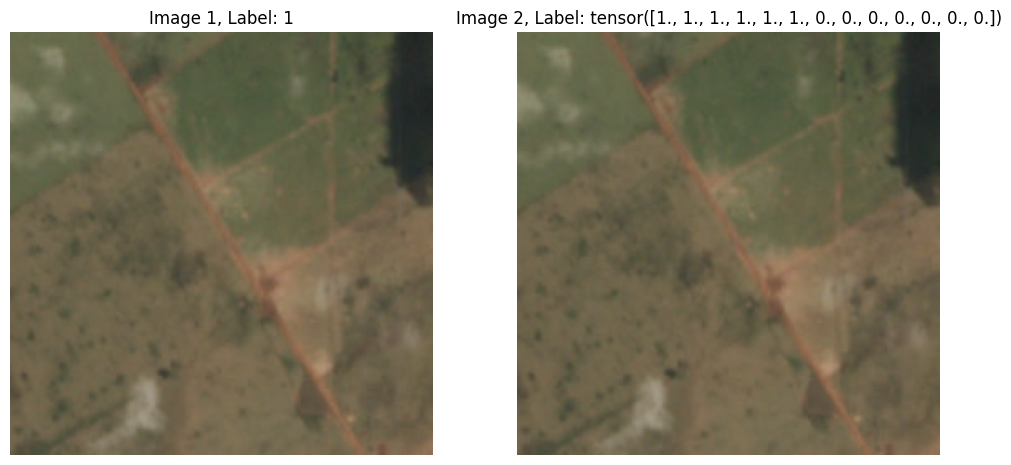

In [65]:
# check if both datasets have the same shuffeling
# Show a sample

random_idx = torch.randint(0, len(train_features_batch_1), size=[1]).item()
img_1, label_1 = train_features_batch_1[random_idx], train_labels_batch_1[random_idx]
img_2, label_2 = train_features_batch_2[random_idx], train_labels_batch_2[random_idx]
# Transpose the image from (3, height, width) to (height, width, 3)
img_denormalized_1 = denormalize(img_1)
img_denormalized_2 = denormalize(img_2)

image_transposed_1 = np.transpose(img_denormalized_1, (1, 2, 0))
image_transposed_2 = np.transpose(img_denormalized_2, (1, 2, 0))

image_transposed_1 = np.clip(image_transposed_1, 0, 1)
image_transposed_2 = np.clip(image_transposed_2, 0, 1)
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) # You can adjust the figsize as needed

# Plot the first image
axs[0].imshow(image_transposed_1)
axs[0].set_axis_off()  # This turns off the axis for the first subplot
axs[0].set_title(f"Image 1, Label: {label_1}")

# Plot the second image
axs[1].imshow(image_transposed_2)
axs[1].set_axis_off()  # This turns off the axis for the second subplot
axs[1].set_title(f"Image 2, Label: {label_2}")

### 8.2 Train model with weather label in mulitclass Classification

In this chapter we will train a model which is a multiclass problem with a pretrained cnn model:

We tested several CNN pretrained networks from the pythorch vison library but the ther ewas no major difference between them. Finally we choose Resnet50 becuase it is one of the most efficient one to train compared to vgg16 or Resnet18

As an optimizer we tested also two apporaches with ` torch.optim.SGD` and ` torch.optim.Adam`. There was no major difference.

Because we use a mulitclass and not a mulitlabel classifaction this time, we need to change our loss function to a `CrossEntropyLoss`

In [66]:
# Import for this section
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from helper_functions import accuracy_fn

#Model setup
model_4 = models.resnet50(pretrained=True)
#Modify the last fully connected layer for multi-label classification
model_4.fc = nn.Linear(model_4.fc.in_features, 4)

LEARNIN_RATE_CNN_PRETRAINED_1 = 0.015
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=LEARNIN_RATE_CNN_PRETRAINED_1, momentum=0.9)
# Debug tests
#optimizer = torch.optim.SGD(model_4.parameters(), lr=0.0001, momentum=0.9)
#optimizer = torch.optim.Adam(model_4.parameters(), lr=0.00001)
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME_4
if os.path.exists(MODEL_SAVE_PATH):
  # Load in the saved model
  model_4.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
  model_4.to(device)
  print('Model laoded from directory')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


Model laoded from directory


In [ ]:
# Train the model

# Show Hyperparameter to user:
print("Model 4 will be trained with the folowing parameters:")
print(f"The parameter LEARNIN_RATE_CNN_PRETRAINED_1 is set to: {LEARNIN_RATE_CNN_PRETRAINED_1}")
print(f"The parameter EPOCHS_CNN_PRETRAINED_1  is set to: {EPOCHS_CNN_PRETRAINED_1 }")

print("For the dataset we have used the folowing parameters: ")
print(f"BATCH_SIZE is set to: {BATCH_SIZE}")
print(f"IMAGE_RESOLUTION_TRAIN_RESNET is set to: {IMAGE_RESOLUTION_TRAIN_RESNET} * {IMAGE_RESOLUTION_TRAIN_RESNET}")
print(f"TEST_SIZE is set to: {TEST_SIZE}")
EPOCHS_CNN_PRETRAINED_1 = 3
# Set Reuslts Dictionary
results_model_04 = { "train_loss": [],
                    "train_accuracy" : [],
                    "test_loss": [],
                    "test_accuracy" : [],
                    "train_score": [],
                    "test_score" : []
}
#measure Time
from timeit import default_timer as timer
train_time_start_model_4 = timer()
model_4 = model_4.to(device)

for epoch in range(EPOCHS_CNN_PRETRAINED_1):
    model_4.train()
    running_loss_training = 0.0
    train_acc = 0
    for inputs, targets in tqdm(train_dataloader_1, desc="Training Batches....."):
        # Assuming targets are already encoded for each class
        # targets shape should be (batch_size, num_classes)

        inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU

        optimizer.zero_grad()

        outputs = model_4(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        train_acc += accuracy_fn(y_true=targets, y_pred=predicted)
        running_loss_training += loss.item()
    train_acc /= len(train_dataloader_1)
    print(f'Epoch [{epoch+1}/{EPOCHS_CNN_PRETRAINED_1}], Loss: {running_loss_training/len(train_dataloader_1):.4f}')
    print(f'Train Accuracy: {train_acc:.2f}%')
    # Validate the model
    model_4.eval()
    total = 0
    correct = 0
    score_val = 0
    running_loss_test = 0.0
    test_acc = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader_1, desc="Testing Batches....."):
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU

            outputs = model_4(inputs)
            _, predicted = torch.max(outputs, 1)
            loss = loss_fn(outputs, targets)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            test_acc += accuracy_fn(y_true=targets, y_pred=predicted)
            running_loss_test += loss.item()

    test_acc /= len(test_dataloader_1)
    print(f'Epoch [{epoch+1}/{EPOCHS_CNN_PRETRAINED_1}], Loss: {running_loss_test/len(test_dataloader_1):.4f}')
    print(f'Validation Accuracy: {test_acc:.2f}%')
    # Update results dictionary
    train_loss = running_loss_training/len(train_dataloader_1)
    test_loss = running_loss_test/len(test_dataloader_1)

    results_model_04["test_loss"].append(test_loss)
    results_model_04["train_loss"].append(train_loss)
    results_model_04["train_accuracy"].append(train_acc)
    results_model_04["test_accuracy"].append(test_acc)
    #Debug to stop training early
    if test_acc > 93:
      break

train_time_end_model_4 = timer()
total_train_time_model_4 = show_train_time(start=train_time_start_model_4, end=train_time_end_model_4)
print('Training Model 4 complete')

Model 4 will be trained with the folowing parameters:
The parameter LEARNIN_RATE_CNN_PRETRAINED_1 is set to: 0.015
The parameter EPOCHS_CNN_PRETRAINED_1  is set to: 7
For the dataset we have used the folowing parameters: 
BATCH_SIZE is set to: 50
IMAGE_RESOLUTION_TRAIN_RESNET is set to: 224 * 224
TEST_SIZE is set to: 0.2


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.2845
Train Accuracy: 89.70%


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch [1/3], Loss: 0.1883
Validation Accuracy: 92.88%


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch [2/3], Loss: 0.1933
Train Accuracy: 92.69%


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch [2/3], Loss: 0.1869
Validation Accuracy: 93.02%
Train time on None: 880.340 seconds
Training Model 4 complete


In [ ]:
results_model_04["train_accuracy"]

[89.7003367003367, 92.68509165731388]

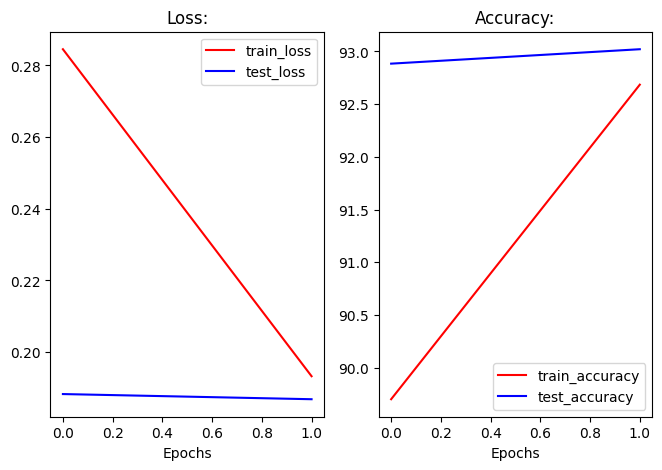

In [ ]:
# Show Loss and Accuracy Plot for model 4
plot_loss_values(results_model_04)

In [75]:
model_4_results = model_rating(
    model=model_4,
    data_loader=test_dataloader_1,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device,
    multiclass=True
)
model_4_results

  0%|          | 0/162 [00:00<?, ?it/s]

{'model_name': 'ResNet',
 'model_loss': 0.1950741410255432,
 'model_acc': 92.7241009125067,
 'model_score': 0.0}

### 8.3 Train model with other label in multilabel Classification
In this chapter we will train a model which is a multiclass problem with a pretrained cnn model:

We tested several CNN pretrained networks from the pythorch vison library but the ther ewas no major difference between them. Finally we choose Resnet50 becuase it is one of the most efficient one to train compared to vgg16 or Resnet18

As an optimizer we tested also two apporaches with torch.optim.SGD and torch.optim.Adam. There was no major difference.

Because we use a multilabel and not a multiclass classifaction this time, we need to change our loss function back to `BCEWithLogitsLoss`

In [76]:
# Import for this section
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# # Model setup
model_5 = models.vgg16(pretrained=True)
# # Modify the last layer for multi-label classification
model_5.classifier[6] = nn.Linear(model_5.classifier[6].in_features, 13)

#Model setup Debug with other resnet model
#model_5 = models.resnet18(pretrained=True)
# #Modify the last fully connected layer for multi-label classification
#model_5.fc = nn.Linear(model_5.fc.in_features, 13)


LEARNIN_RATE_CNN_PRETRAINED_2 =0.02
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(params=model_5.parameters(), lr=0.0003)
#optimizer = torch.optim.SGD(model_5.parameters(), lr=0.015, momentum=0.9) #resenet
optimizer = torch.optim.SGD(model_5.parameters(), lr=LEARNIN_RATE_CNN_PRETRAINED_2, momentum=0.9) #vgg16
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME_5
if os.path.exists(MODEL_SAVE_PATH):
  # Load in the saved model
  model_5.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
  model_5.to(device)
  print('Model laoded from directory')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 183MB/s]


RuntimeError: ignored

In [ ]:
# Train the model
EPOCHS_CNN_PRETRAINED_2 = 6
# Show Hyperparameter to user:
print("Model 5 will be trained with the folowing parameters:")
print(f"The parameter LEARNIN_RATE_CNN_PRETRAINED_2 is set to: {LEARNIN_RATE_CNN_PRETRAINED_2}")
print(f"The parameter EPOCHS_Pytorch  is set to: {EPOCHS_Pytorch }")

print("For the dataset we have used the folowing parameters: ")
print(f"BATCH_SIZE is set to: {BATCH_SIZE}")
print(f"IMAGE_RESOLUTION_TRAIN_RESNET is set to: {IMAGE_RESOLUTION_TRAIN_RESNET} * {IMAGE_RESOLUTION_TRAIN_RESNET}")
print(f"TEST_SIZE is set to: {TEST_SIZE}")
# Set Reuslts Dictionary
results_model_05 = { "train_loss": [],
                    "train_accuracy" : [],
                    "test_loss": [],
                    "test_accuracy" : [],
                    "train_score": [],
                    "test_score" : []
}
#measure Time
from timeit import default_timer as timer
train_time_start_model_5 = timer()
model_5 = model_5.to(device)
for epoch in range(EPOCHS_CNN_PRETRAINED_2):
    model_5.train()
    running_loss_training = 0.0
    total = 0
    correct = 0
    train_score_val = 0
    for inputs, targets in tqdm(train_dataloader_2, desc="Training Batches....."):
        # Assuming targets are already encoded for each class
        # targets shape should be (batch_size, num_classes)

        inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU

        optimizer.zero_grad()

        outputs = model_5(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss_training += loss.item()

        predicted = torch.sigmoid(outputs).data > 0.5
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        train_score_val += fbeta_score(targets.cpu().numpy(), predicted.cpu().numpy(), beta=2, average="samples", zero_division=1) * 100

    train_score_val /= len(test_dataloader_2)
    train_accuracy = 100 * correct / (total * 13)

    print(f'Epoch [{epoch+1}/{EPOCHS_CNN_PRETRAINED_2}], Loss: {running_loss_training/len(train_dataloader_2):.4f}')
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    print(f'Test F-2 Score: {test_score_val:.2f}%')

    # Validate the model
    model_5.eval()
    total = 0
    correct = 0
    test_score_val = 0
    running_loss_test = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader_2, desc="Testing Batches....."):
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU

            outputs = model_5(inputs)
            loss = loss_fn(outputs, targets)
            running_loss_test += loss.item()
            predicted = torch.sigmoid(outputs).data > 0.5
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            test_score_val += fbeta_score(targets.cpu().numpy(), predicted.cpu().numpy(), beta=2, average="samples", zero_division=1) * 100

    test_score_val /= len(test_dataloader_2)
    test_accuracy = 100 * correct / (total * 13)
    print(f'Epoch [{epoch+1}/{EPOCHS_CNN_PRETRAINED_2}], Loss: {running_loss_test/len(test_dataloader_2):.4f}')
    print(f'Validation Accuracy: {test_accuracy:.2f}%')
    print(f'Validation F-2 Score: {test_score_val:.2f}%')
    # Update results dictionary
    train_loss = running_loss_training/len(train_dataloader_2)
    test_loss = running_loss_test/len(test_dataloader_2)

    results_model_05["train_loss"].append(train_loss)
    results_model_05["test_accuracy"].append(test_accuracy)
    results_model_05['test_score'].append(test_score_val)
    results_model_05["test_loss"].append(test_loss)
    results_model_05["train_accuracy"].append(train_accuracy)
    results_model_05['train_score'].append(train_score_val)

train_time_end_model_5 = timer()
total_train_time_model_5 = show_train_time(start=train_time_start_model_5, end=train_time_end_model_5)
print('Training Model 5 complete')

Model 5 will be trained with the folowing parameters:
The parameter LEARNIN_RATE_CNN_PRETRAINED_2 is set to: 0.02
The parameter EPOCHS_Pytorch  is set to: 15
For the dataset we have used the folowing parameters: 
BATCH_SIZE is set to: 50
IMAGE_RESOLUTION_TRAIN_RESNET is set to: 224 * 224
TEST_SIZE is set to: 0.2


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch [1/6], Loss: 0.1130
Test Accuracy: 96.22%
Test F-2 Score: 89.79%


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch [1/6], Loss: 0.0988
Validation Accuracy: 96.31%
Validation F-2 Score: 88.75%


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch [2/6], Loss: 0.0910
Test Accuracy: 96.31%
Test F-2 Score: 88.75%


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch [2/6], Loss: 0.0948
Validation Accuracy: 96.45%
Validation F-2 Score: 89.38%


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch [3/6], Loss: 0.0835
Test Accuracy: 96.45%
Test F-2 Score: 89.38%


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch [3/6], Loss: 0.0930
Validation Accuracy: 96.52%
Validation F-2 Score: 89.81%


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch [4/6], Loss: 0.0768
Test Accuracy: 96.52%
Test F-2 Score: 89.81%


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch [4/6], Loss: 0.0925
Validation Accuracy: 96.55%
Validation F-2 Score: 89.98%


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch [5/6], Loss: 0.0702
Test Accuracy: 96.55%
Test F-2 Score: 89.98%


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch [5/6], Loss: 0.0946
Validation Accuracy: 96.48%
Validation F-2 Score: 90.13%


Training Batches.....:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch [6/6], Loss: 0.0627
Test Accuracy: 96.48%
Test F-2 Score: 90.13%


Testing Batches.....:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch [6/6], Loss: 0.1005
Validation Accuracy: 96.39%
Validation F-2 Score: 89.97%
Train time on None: 3885.445 seconds
Training Model 5 complete


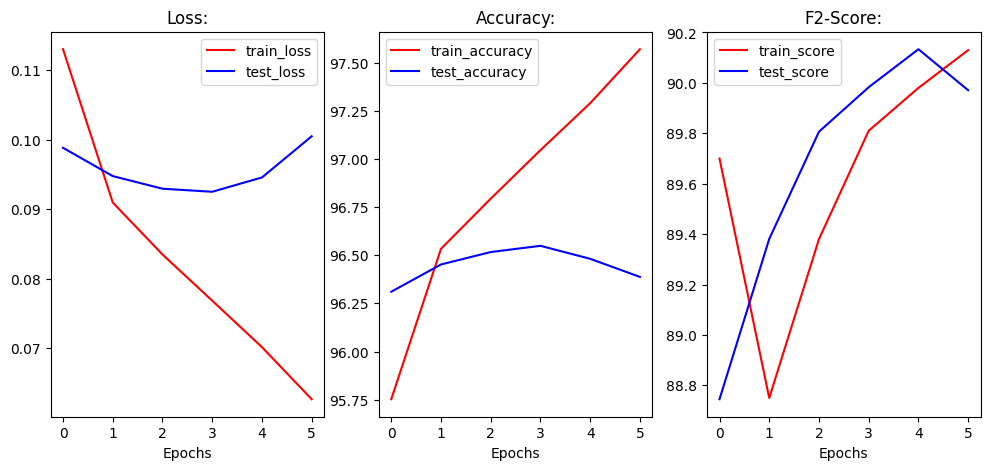

In [ ]:
# Show Loss and Accuracy Plot for model 5
plot_loss_values(results_model_05)

In [ ]:
model_5_results = model_rating(
    model=model_5,
    data_loader=test_dataloader_2,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_5_results

## 9. Comparing different Models and approaches

In this chapter we would like to make some comparisons between the three different approaches in Pytorch with neural networks.

Therefore we would like to comapre the accuracy of the model also together with the used training time.

This chapter covers the folowing steps:
* Bar diagram with the accurcy comparison between the three models
* Overview about the used training time for every model.
* Confusion Matrix for multi-label classification


### 9.0 Define data to use for test

First of all, we need to set up or define the data we would like to use to make some predictions with it or use for comparisons. There we do not want to use the pytorch dataloder structure, so we create a new array with all the test images in there. We use the same random_state to garantee to have the same test data as during training/validation:





In [ ]:
# setting up the array of data
test_images = []
test_labels = []
test_labels_2 = []
for sample, label in dataset_test_1:
    test_images.append(sample)  # Assuming sample is your image
    test_labels.append(label)

for sample, label in dataset_test_2:
    test_labels_2.append(label)

for index in range(test_labels):
  test_labels[index] = test_labels[index] + test_labels_2[index]


test_images_data = torch.stack(test_images)  # Stacks your list of images into a single tensor

test_labels[0]

TypeError: ignored

In [ ]:
test_labels[0]

2

### 9.1 General comaprison model_1-model_5

In this capter we compare and show the different accuracies and also display the needed training time:

First of all we need to calculate the score for the combined model04 and model_05


In [ ]:
# get results, do not specify the threshold because we would like to have teh raw values from mulitlabel classification
pred_probs_combined_4_5 = make_pred_combined(multiclass_model=model_4,
                                            multilabel_model=model_5,
                                            data=test_images,
                                            device=device,
                                             threshold=0.5)

In [ ]:
test_labels[0]

array([0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
pred_probs_combined_4_5[0]

tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
pred_probs_combined_4_5 = torch.cat(pred_probs_combined_4_5, dim=0)

In [ ]:
#Calculate score for combined model
test_labels_int = []
score_val = 0
# get results, do not specify the threshold because we would like to have teh raw values from mulitlabel classification

for i in range(len(test_labels)):
    test_labels_int.append(test_labels[i].astype(int))

# Check out the best threshold for this model
# Define mehtod to check this
def find_best_thresholds(Y_hat_list, Y):
    # Convert Y_hat_list (list of tensors) to a single tensor
    Y_hat = torch.stack(Y_hat_list)

    # Ensure Y is a NumPy array and has the same shape as Y_hat
    Y = np.array(Y)
    assert Y.shape == Y_hat.shape, "Shape mismatch between Y_hat and Y"

    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100

    # Convert threshs to a PyTorch tensor, ensuring compatibility with Y_hat
    threshs_tensor = torch.tensor(best_threshs, dtype=Y_hat.dtype, device=Y_hat.device)

    for jdx in tqdm(range(N_tags)):
        best_score = 0
        threshs = threshs_tensor.clone()
        for kdx in range(resolution):
            kdx_value = float(kdx) / resolution
            threshs[jdx] = kdx_value
            Y_hat_thresh = (Y_hat > threshs).float()

            # Ensure Y_hat_thresh is on CPU and in NumPy format for fbeta_score
            score = fbeta_score(Y, Y_hat_thresh.cpu().numpy(), beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx_value

    global_best_score = fbeta_score(Y, (Y_hat > torch.tensor(best_threshs, dtype=Y_hat.dtype, device=Y_hat.device)).float().cpu().numpy(), beta=2, average="samples")
    print(f"Thresholds: {best_threshs} -- Best score: {global_best_score}")

    return best_threshs

# Convert Y_hat to a PyTorch tensor if it's not already

threshs = find_best_thresholds(pred_probs_combined_4_5, test_labels)
threshs


  0%|          | 0/17 [00:00<?, ?it/s]

Thresholds: [0.0, 0.0, 0.0, 0.0, 0.02, 0.03, 0.37, 0.11, 0.02, 0.19, 0.96, 0.12, 0.31, 0.36, 0.58, 0.91, 0.25] -- Best score: 0.8571946671065934


RuntimeError: ignored

In [ ]:
test_labels_np = np.array(test_labels)
pred_probs_combined_4_5_np = torch.stack(pred_probs_combined_4_5)
fbeta_score(test_labels_np, pred_probs_combined_4_5_np, beta=2, average="samples", zero_division=1) * 100

83.6062381550778

In [ ]:
for i in range(4):
    threshs[i] = 0.5
threshs


[0.5,
 0.5,
 0.5,
 0.5,
 0.02,
 0.03,
 0.37,
 0.11,
 0.02,
 0.19,
 0.96,
 0.12,
 0.31,
 0.36,
 0.58,
 0.91,
 0.25]

In [ ]:
pred_probs_combined_4_5[0]

tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 9.9996e-01, 1.5335e-02,
        3.1950e-03, 2.6335e-03, 7.3212e-04, 3.7808e-02, 3.5569e-04, 7.2436e-05,
        1.0329e-03, 4.0252e-05, 1.4221e-02, 1.9338e-03, 8.1969e-03])

In [ ]:
score_val = fbeta_score(np.array(test_labels), (torch.stack(pred_probs_combined_4_5) > torch.tensor(threshs)).float().cpu().numpy(), beta=2, average="samples")*100
score_val

85.71946671065935

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_1_results,
                                model_2_results,
                                model_3_results])

compare_results

In [ ]:
# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model_1,
                                    total_train_time_model_2,
                                    total_train_time_model_3]
compare_results

In [ ]:
#do a combined plot with accuracy and training time
import matplotlib.pyplot as plt
import pandas as pd

# Data setup
model_names = ["Base Model", "CNN Model", "ResNet Model"]
accuracy_scores = compare_results["model_acc"]
training_times = compare_results["training_time"]

# Create a figure with subplots
fig, ax1 = plt.subplots()

# Plot accuracy on the primary y-axis
bars = ax1.bar(model_names, accuracy_scores, color='b', alpha=0.7, label='Accuracy (%)')
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylim([0, 100])

# Create a secondary y-axis for training times
ax2 = ax1.twinx()
ax2.plot(model_names, training_times, color='r', marker='o', label='Training Time (s)')
ax2.set_ylabel('Training Time (s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='lower right')

# Add numbers on top of the bars
for bar, score in zip(bars, accuracy_scores):
    ax1.text(bar.get_x() + bar.get_width() / 2, score + 2, f'{score:.2f}', ha='center', va='bottom')

# Title
plt.title('Comparison of Models')

# Show the plot
plt.show()


In [ ]:
#do a combined plot with score and training time
import matplotlib.pyplot as plt
import pandas as pd

# Data setup
model_names = ["Base Model", "CNN Model", "ResNet Model"]
accuracy_scores = compare_results["model_score"]
training_times = compare_results["training_time"]

# Create a figure with subplots
fig, ax1 = plt.subplots()

# Plot score on the primary y-axis
bars = ax1.bar(model_names, accuracy_scores, color='b', alpha=0.7, label='F-2S Score (%)')
ax1.set_xlabel('Models')
ax1.set_ylabel('F-2 Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylim([0, 100])

# Create a secondary y-axis for training times
ax2 = ax1.twinx()
ax2.plot(model_names, training_times, color='r', marker='o', label='Training Time (s)')
ax2.set_ylabel('Training Time (s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='lower right')

# Add numbers on top of the bars
for bar, score in zip(bars, accuracy_scores):
    ax1.text(bar.get_x() + bar.get_width() / 2, score + 2, f'{score:.2f}', ha='center', va='bottom')

# Title
plt.title('Comparison of Models')

# Show the plot
plt.show()

In [ ]:
# Visualize just the accuracy of differnt models
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

### 8.2 combining results of `model_4` and `model_5` together

In this chapter, we would like to combine the two trained models  `model_4` and `model_5` to use it with the dataset

### 8.3 Predictions with random data

This chapter make some random predictions from the test dataset:

In [ ]:
import random
# Set random seed

# Epty lists for the k random values
indices = list(range(len(dataset_test)))  # Assuming dataset_test is your CustomImageDataset instance
selected_indices = random.sample(indices, k=9)

test_samples = []
test_labels = []

for idx in selected_indices:
    sample, label = dataset_test[idx]  # Use the __getitem__ implementation
    if sample is not None and label is not None:
        test_samples.append(sample)
        test_labels.append(label)
    else:
        print(f"Skipping index {idx} due to previous error.")

# View the first sample shape
len(test_samples), test_samples[0].shape
test_samples[0].shape

#### 8.2.1 Make predictions with `model_1`

Based on the random selection in the block above, we will now make some predictions for the model 1 and show the results in a plot:

In [ ]:
# Make predictions fro model 1
pred_probs_1 = make_pred(model=model_1,
                              data=test_samples,
                              device=device)

# view first  predictions probabilities
pred_probs_1[0]

#### 8.2.2 Make predictions with `model_2`

Based on the random selection in the block above, we will now make some predictions for the model 2 and show the results in a plot:

In [ ]:
# Make predictions fro model 2
pred_probs_2 = make_pred(model=model_2,
                              data=test_samples, device=device)

# view first two predictions probabilities
pred_probs_2[0]

#### 8.2.3 Make predictions with `model_3`

Based on the random selection in the block above, we will now make some predictions for the model 3 and show the results in a plot:

In [ ]:
# Make predictions fro model 3
pred_probs_3 = make_pred(model=model_3,
                              data=test_samples, device=device)

# view first two predictions probabilities
pred_probs_3[0]

#### 8.2.3 Make predictions with the combined in modules `module_4`
 and `module_5`
Based on the random selection in the block above, we will now make some predictions with the combined module 4 and module5. Therefore we use method `make_pred_combined` which we have defined at the beginning of this document.

In [ ]:
pred_probs_combined_4_5 = make_pred_combined(multiclass_model=model_4,
                                            multilabel_model=model_5,
                                            data=test_samples,
                                            device=device)

In [ ]:
import matplotlib.pyplot as plt

# Helper function to add colored text for some parts of a plot title
def add_colored_text(ax, ypos, label_prefix, labels, truth_labels, fontsize=6):
    x_offset = 0  # Initialize x_offset to start text after the label_prefix
    ax.text(x_offset, ypos, label_prefix, fontsize=fontsize, transform=ax.transAxes, verticalalignment='top', color='black')
    x_offset += ax.get_window_extent().width * 0.0009 # Faktor has to be found out, now 0.0009 seems to be good

    # Go through each label and color it appropriately
    for label in labels:
        color = 'green' if label in truth_labels else 'red'
        label_text = ax.text(x_offset, ypos, label + ', ', fontsize=fontsize, transform=ax.transAxes, verticalalignment='top', color=color)
        x_offset += len(label)*0.0265 # #Faktor has to be found out, now 0.265 seems to be good

def add_colored_text_truth(ax, ypos, label_prefix, labels, truth_labels, fontsize=6):
    x_offset = 0  # Initialize x_offset to start text after the label_prefix
    ax.text(x_offset, ypos, label_prefix, fontsize=fontsize, transform=ax.transAxes, verticalalignment='top', color='black')
    x_offset += ax.get_window_extent().width * 0.0007  # Faktor has to be found out, now 0.0007 seems to be good

    # Go through each label and color it appropriately
    for label in labels:
        color = 'black' if label in truth_labels else 'red'
        label_text = ax.text(x_offset, ypos, label + ', ', fontsize=fontsize, transform=ax.transAxes, verticalalignment='top', color=color)
        x_offset += len(label)*0.0265 #Faktor has to be found out, now 0.265 seems to be good


# Plot prediction
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    # Create subplot
    ax = plt.subplot(nrows, ncols, i+1)

    # Trasnpose sample
    img_denormalized = denormalize(sample)
    image_transposed = np.transpose(img_denormalized, (1, 2, 0))
    image_transposed = np.clip(image_transposed, 0, 1)
    #sample_permuted = sample.permute(1, 2, 0)

    # plot target image
    plt.imshow(image_transposed)
    threshold =0.5

    # Split labels into lists
    pred_labels_1 = [class_names_tags[i] for i, val in enumerate(pred_probs_1[i]) if val > threshold]
    pred_labels_2 = [class_names_tags[i] for i, val in enumerate(pred_probs_2[i]) if val > threshold]
    pred_labels_3 = [class_names_tags[i] for i, val in enumerate(pred_probs_3[i]) if val > threshold]
    pred_labels_4 = [class_names_tags[i] for i, val in enumerate(pred_probs_combined_4_5[i]) if val > threshold]
    truth_labels = [class_names_tags[index] for index, value in enumerate(test_labels[i]) if value == 1]

    text_truth_label = "Truth: "+ ','.join([class_names_tags[index] for index, value in enumerate(test_labels[i]) if value == 1]) # Set title according to label matrix and class_name_tags

    all_pred_labels = []


    all_labels_for_current_sample = pred_labels_1 + pred_labels_2 + pred_labels_3 + pred_labels_4
    # Add colored text for each label set
    #ax.text(0, 1.4, text_truth_label, fontsize=7, transform=ax.transAxes, verticalalignment='top', color='black')

    add_colored_text_truth(ax, 1.4, 'Truth: ', truth_labels, all_labels_for_current_sample)
    add_colored_text(ax, 1.3, 'Pred_1: ', pred_labels_1, truth_labels)
    add_colored_text(ax, 1.2, 'Pred_2: ', pred_labels_2, truth_labels)
    add_colored_text(ax, 1.1, 'Pred_3: ', pred_labels_3, truth_labels)
    add_colored_text(ax, 1.1, 'Pred_4: ', pred_labels_4, truth_labels)

    plt.axis('off')

# Adjust subplot parameters to give specified padding.
plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.9)

plt.show()  # Display the figure


#### 8.3 Confusion Matrix model_1 - model_3

In this chapter, we perform predictions with the whole test dataset and show the labels in the confusion Matrix:


#### 8.3.1 Preparations data for the predictions
Here we setup the data for latter running the preditions for each model.


In [ ]:
pred_probs_combined_np = make_pred_combined(multiclass_model=model_4,
                                            multilabel_model=model_5,
                                            data=test_images,
                                            device=device)

In [ ]:
# pred_probs_combined = [combine_models_predictions_2(pred_probs_5[index], pred_probs_4[index]) for index in range(len(pred_probs_5))]
# pred_probs_combined_np = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in pred_probs_combined]

# pred_probs_combined_np[0]

In [ ]:
for i in range(len(test_labels)):
    test_labels[i] = test_labels[i].astype(int)
test_labels[0]

#### 8.3.2 Confusion Matrix model_1
By the reason we have a multi-label classification problem, we need to perform a confusion matrix for every label. Therefore we use the `multilabel_confusion_matrix` from sklearn

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# view first  predictions probabilities
y_pred_probs_1 = make_pred(model=model_1,
                              data=test_images_data,
                              device=device)
# print(y_pred_probs_1.shape)
# Set the predictgions and the ground thruth labels
# Choose a threshold to convert probabilities into binary predictions
threshold = 0.5
y_pred = (y_pred_probs_1 > threshold).int()
y_true = test_labels

# Get the confusion matrix for each class
multilabel_cm_1 = multilabel_confusion_matrix(y_true, y_pred)

# Plot confusion matrix for each class
num_classes = multilabel_cm_1.shape[0]
for i in range(num_classes):
    plt.figure()
    sns.heatmap(multilabel_cm_1[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Class {class_names_tags[i]}')
    plt.show()

#### 8.3.3 Confusion Matrix model_2
By the reason we have a multi-label classification problem, we need to perform a confusion matrix for every label. Therefore we use the `multilabel_confusion_matrix` from sklearn

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# view first  predictions probabilities
y_pred_probs_1 = make_pred(model=model_2,
                              data=test_images_data,
                              device=device)
# print(y_pred_probs_1.shape)
# Set the predictgions and the ground thruth labels
# Choose a threshold to convert probabilities into binary predictions
threshold = 0.5
y_pred = (y_pred_probs_1 > threshold).int()
y_true = test_labels

# Get the confusion matrix for each class
multilabel_cm_2 = multilabel_confusion_matrix(y_true, y_pred)

# Plot confusion matrix for each class
num_classes = multilabel_cm_2.shape[0]
for i in range(num_classes):
    plt.figure()
    sns.heatmap(multilabel_cm_2[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Class {class_names_tags[i]}')
    plt.show()

#### 8.3.4 Confusion Matrix model_3
By the reason we have a multi-label classification problem, we need to perform a confusion matrix for every label. Therefore we use the `multilabel_confusion_matrix` from sklearn

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# view first  predictions probabilities
y_pred_probs_1 = make_pred(model=model_3,
                              data=test_images_data,
                              device=device)
# print(y_pred_probs_1.shape)
# Set the predictgions and the ground thruth labels
# Choose a threshold to convert probabilities into binary predictions
threshold = 0.5
y_pred = (y_pred_probs_1 > threshold).int()
y_true = test_labels

# Get the confusion matrix for each class
multilabel_cm_3 = multilabel_confusion_matrix(y_true, y_pred)

# Plot confusion matrix for each class
num_classes = multilabel_cm_3.shape[0]
for i in range(num_classes):
    plt.figure()
    sns.heatmap(multilabel_cm_3[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Class {class_names_tags[i]}')
    plt.show()

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# view first  predictions probabilities
y_pred_probs_4 = make_pred(model=model_4,
                              data=test_images_data,
                              device=device)
# view first  predictions probabilities
y_pred_probs_5 = make_pred(model=model_5,
                              data=test_images_data,
                              device=device)

# # print(y_pred_probs_1.shape)
# # Set the predictgions and the ground thruth labels
# # Choose a threshold to convert probabilities into binary predictions
# threshold = 0.5
# y_pred = (y_pred_probs_1 > threshold).int()
# y_true = test_labels

# # Get the confusion matrix for each class
# multilabel_cm_3 = multilabel_confusion_matrix(y_true, y_pred)

# # Plot confusion matrix for each class
# num_classes = multilabel_cm_3.shape[0]
# for i in range(num_classes):
#     plt.figure()
#     sns.heatmap(multilabel_cm_3[i], annot=True, fmt='d', cmap='Blues',
#                 xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title(f'Confusion Matrix for Class {class_names_tags[i]}')
#     plt.show()

### 8.4 Further prediction analysis

In this chapter, we would like to display which classes have the highest number of FALSE positive or FALSE negative values and compare them also with the different models:

#### 8.4.1 Get data for Bar chart for all three models

In [ ]:
# Initialize arrays to store sums of false positives and false negatives for each class for all models
fp_counts = np.zeros((num_classes, 3))  # Three columns for three models
fn_counts = np.zeros((num_classes, 3))

# Define a function to extract false positives and negatives from confusion matrices
def extract_fp_fn(confusion_matrix):
    fp = confusion_matrix[:, 0, 1]  # False Positives are at position (0, 1)
    fn = confusion_matrix[:, 1, 0]  # False Negatives are at position (1, 0)
    return fp, fn

# Get the data for each model
fp_counts[:, 0], fn_counts[:, 0] = extract_fp_fn(multilabel_cm_1)
fp_counts[:, 1], fn_counts[:, 1] = extract_fp_fn(multilabel_cm_2)
fp_counts[:, 2], fn_counts[:, 2] = extract_fp_fn(multilabel_cm_3)


In [ ]:
# Set up the bar width and positions
bar_width = 0.25  # Width of the bars
r1 = np.arange(num_classes)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Define pastel colors in RGB
colors_fn = ['#cc0000', '#0099cc', '#339933']
colors_fp = ['#e67300', '#00b8e6', '#00e600']

# Start plotting
plt.figure(figsize=(20, 10))

# Create stacked bars for False Negatives and False Positives for each model
# Model 1
plt.bar(r1, fn_counts[:, 0], color=colors_fn[0], width=bar_width, edgecolor='grey', label='Model 1 FN')
plt.bar(r1, fp_counts[:, 0], bottom=fn_counts[:, 0], color=colors_fp[0], width=bar_width, edgecolor='grey', label='Model 1 FP')

# Model 2
plt.bar(r2, fn_counts[:, 1], color=colors_fn[1], width=bar_width, edgecolor='grey', label='Model 2 FN')
plt.bar(r2, fp_counts[:, 1], bottom=fn_counts[:, 1], color=colors_fp[1], width=bar_width, edgecolor='grey', label='Model 2 FP')

# Model 3
plt.bar(r3, fn_counts[:, 2], color=colors_fn[2], width=bar_width, edgecolor='grey', label='Model 3 FN')
plt.bar(r3, fp_counts[:, 2], bottom=fn_counts[:, 2], color=colors_fp[2], width=bar_width, edgecolor='grey', label='Model 3 FP')

# Add xticks on the middle of the group bars
plt.xlabel('Classes', fontweight='bold')
plt.ylabel('Count')
plt.xticks([r + bar_width for r in range(len(r1))], class_names_tags, rotation=45)

# Create legend & Show graphic
plt.legend()
plt.title('Stacked False Positives and False Negatives for each class across three models with Pastel Colors')
plt.show()


## 9. Save models

In this chapter, we gone save the three models that we can share them so someone and load it into another system.

In [ ]:
# Save model 1
from pathlib import Path

# Create model directory path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "vision_base_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Save the model state dict
print(f"Savong model to: {MODEL_SAVE_PATH}")
torch.save(obj= model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Savong model to: models/vision_base_model_1.pth


In [ ]:
# Save model 2
from pathlib import Path

# Create model directory path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "vision_cnn_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Save the model state dict
print(f"Savong model to: {MODEL_SAVE_PATH}")
torch.save(obj= model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Savong model to: models/vision_cnn_model_2.pth


In [ ]:
# Save model 3
from pathlib import Path

# Create model directory path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "vision_predefined_model_3.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Save the model state dict
print(f"Savong model to: {MODEL_SAVE_PATH}")
torch.save(obj= model_3.state_dict(),
           f=MODEL_SAVE_PATH)

Savong model to: models/vision_predefined_model_3.pth


In [ ]:
# Save model 4
from pathlib import Path

# Create model directory path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "vision_predefined_model_4.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Save the model state dict
print(f"Savong model to: {MODEL_SAVE_PATH}")
torch.save(obj= model_4.state_dict(),
           f=MODEL_SAVE_PATH)

Savong model to: models/vision_predefined_model_4.pth


In [ ]:
# Save model 5
from pathlib import Path

# Create model directory path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "vision_predefined_model_5.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Save the model state dict
print(f"Savong model to: {MODEL_SAVE_PATH}")
torch.save(obj= model_5.state_dict(),
           f=MODEL_SAVE_PATH)

Savong model to: models/vision_predefined_model_5.pth


## 10. Conclusion
In this conclusion chapter, we would like to conclude the results just from the neural network approaches and make afterwards a final conclusion about the whole project.


###10.1 Basemodel model_01
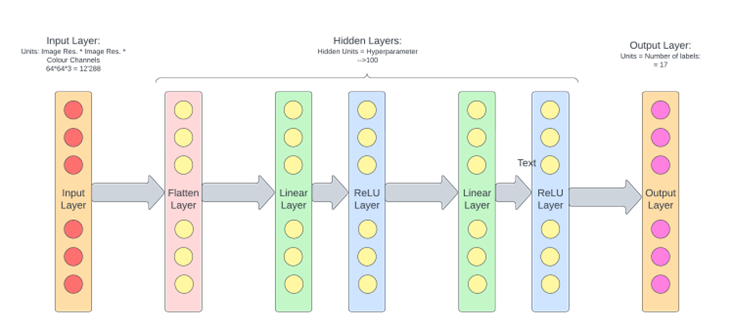

The loss stagnates, which we can interpret as underfitting, but several attempts with different learning rates and numbers of hidden units have not brought any improvement and have only increased the training time. Therefore, we assume that the limits of the neural network do not allow a better result after all.

In this graph we can see the loss of the training set and the evaluation set: The loss is parallel all the time, which shows that we are not encountering overfitting.
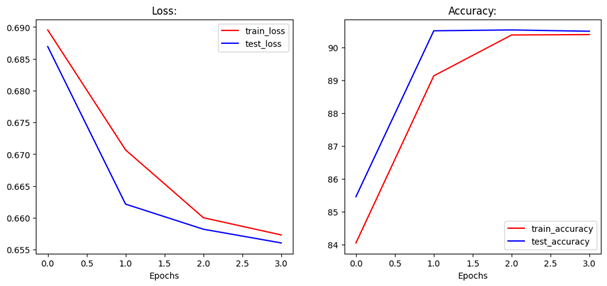

With an accuracy of around 90%, it is not bad either.

Further adjustments we could do:
* Add more layers to the neural network, so for example add more Linear Layers and ReLU layers.
* Try another Loss Function for example CorssEntropyLoss
* Use another optimizer

### 10.2 CNN model_02
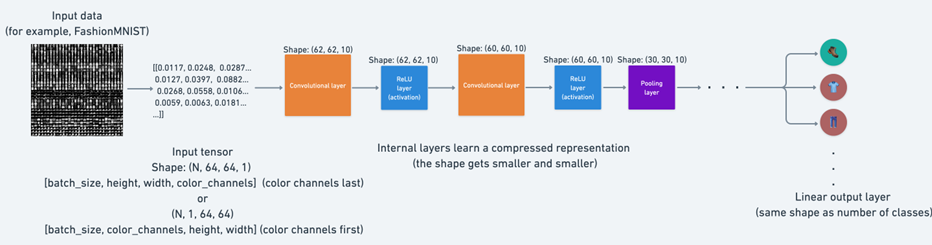

With the CNN model, we hoped for an improvement due to the convolutional layers it contains, which make it possible to solve more complex problems. The different filter layers and the three repeating blocks with the layers Conv2d, ReLU,Conv2d,ReLU,MaxPool2d should help to find small patterns in the images more accurately.

The results of around 95% are also very good. Here you can also clearly see the limit of the module, because after recording the loss curves during training, we can recognize the model close to an overfitting.

This graph is showing an tendency of overfitting in the end because to loss of the test_set tend to stagnaet where the loss of the training_set still improves:
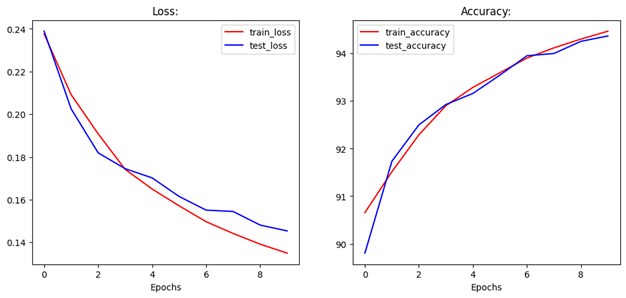

This seems to us to be the only way to achieve improvements by changing the structure of the model.




### 10.3 pretrained model from Pytorch vision library
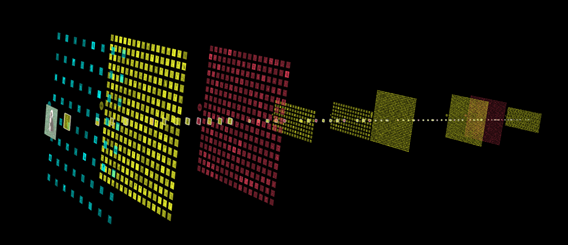

Finally, we tried out a relatively complex model with many layers and around 25,557,032 parameters. This model comes from the Pytorch image processing library and already has pre-trained weights. We only need to train the model specifically for our dataset.

The result is very similar and maybe even slightly better than our CNN network. Here we only run 5 training epochs, which requires less training time than the CNN model.

The limitations here are also related to the model itself. The improvement in accuracy per epoch tends to stagnate, so adjusting the learning curve does not seem to bring any further improvements.



### 10.4 Comparison between the three neural netowrk models (accuracy and training time)
If we compare all three models with each other, we can see that they have very similar accuracy and only minor improvements between them. The biggest difference is between the base model and the CNN models. However, this advantage may turn out to be a disadvantage when we look at the training time.

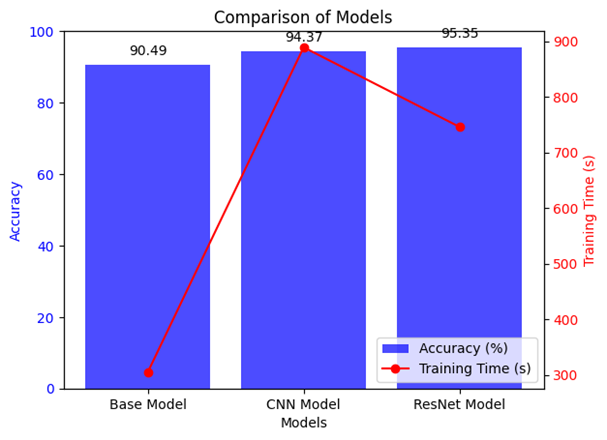

The following graph shows the correlations between training time and accuracy. With the pre-trained pytroch model from the torchvision library, we have the advantage of pre-trained weights, resulting in a shorter training time or fewer epochs compared to the self-developed CNN network.

### 10.5 Comparing results and error rate of the three models

In this section we show a graph which shows the error of FALSE positive and FALSE negative results of all three models:

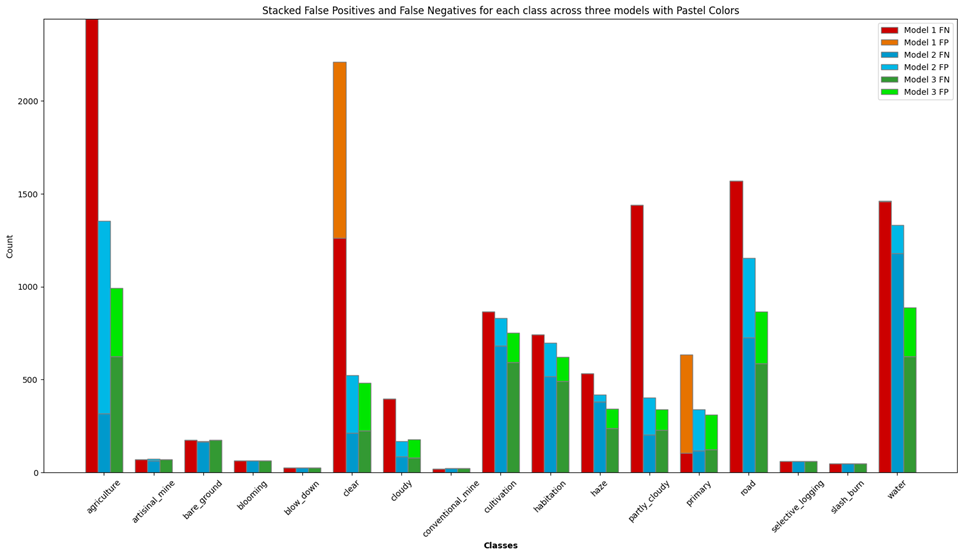


As a conclusion we can recognize the folowing patterns:
* Aggriculture, road and water are the most difficult labels to detect
* We have a tendency to more false negative than false posotive
* Model 1 struggels a lot of labels with false negative



Finally, a subset of 9 images from the test set shows how well the models work. The ground truth is shown in black, followed by the prediction of the model in each row. Each miscalculated label has the corresponding color if the label was correctly identified or not.

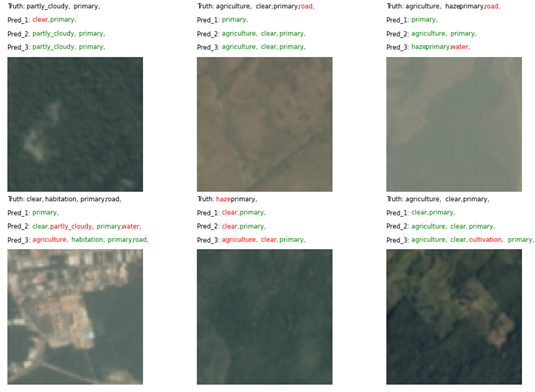